# Imports

In [6]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
import keras.ops
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras import Loss
import seaborn as sns

# Train on single vehicle dynamics

## Constant coefficient car

In [7]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate

        self.X = np.array(x0, dtype=float) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)


        # Rk4
        k1 = self._dynamics(self.X, u)
        a = k1[1] #gets v_dot = actual acceleration
        self.history["a"].append(a)

        k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        k4 = self._dynamics(self.X + dt*k3, u)

        self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        return np.array([v, a])


## Generate synthetic data

In [8]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
x0 = (0, 20/3.6) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)

#DEFINE U
t_samp = np.array([0, 40, 100, 200, 250, t_end]) #time check points
u_samp_train = np.array([0.5, 0.5, -0.1, 0.4, 0.3, 0.1]) * m # traction force (input from engine)
u = interp1d(t_samp, u_samp_train, kind='linear') #quadratic interpolation -> no drivetrain limitation for now

#generate data:
for t_curr in t:
    car.update(u(t_curr), dt)

# for validation later (different trajectory):

### Simulate measurements (add noise)

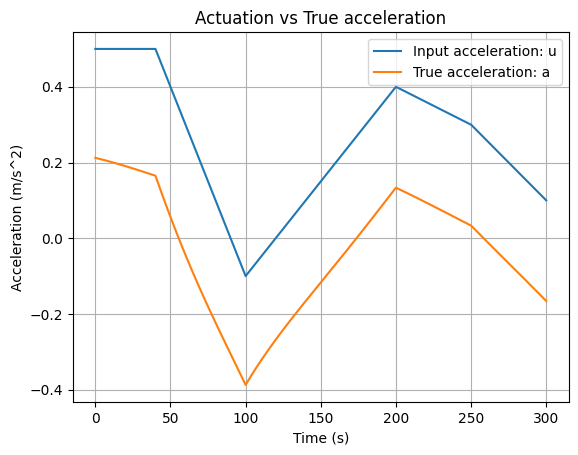

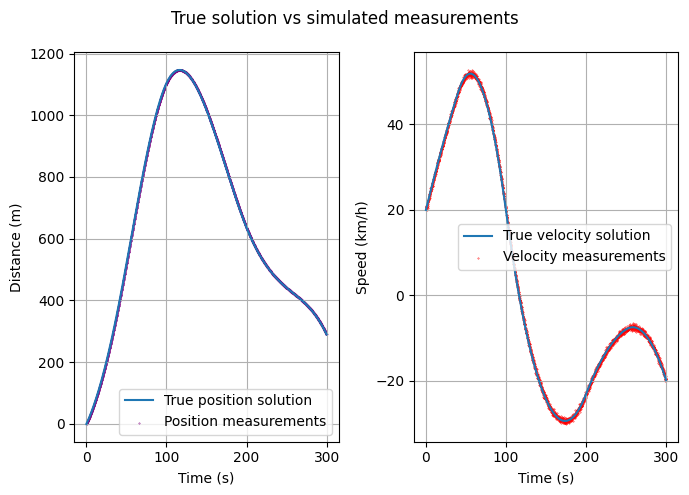

In [9]:
variance = 0.1

x_true = np.array(car.history["x"]).reshape(-1, 1)
v_true = np.array(car.history["v"]).reshape(-1, 1)
Y_true = np.hstack((x_true, v_true))
Y_noise = Y_true + np.random.normal(0, variance, size=Y_true.shape)

plt.plot(t, np.array(car.history["u"])/car.m, label = "Input acceleration: u")
plt.plot(t, car.history["a"], label="True acceleration: a")
plt.title("Actuation vs True acceleration")
plt.grid()
plt.legend();
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
fig = plt.figure(figsize=(7,5))
fig.suptitle("True solution vs simulated measurements")
ax=fig.subplots(1,2)
ax[0].plot(t, Y_true[:, 0], label="True position solution")
ax[0].scatter(t, Y_noise[:, 0], label="Position measurements", s=0.1, color="purple")
ax[0].set_ylabel("Distance (m)")
ax[1].plot(t, Y_true[:, 1]*3.6, label="True velocity solution")
ax[1].scatter(t, Y_noise[:, 1]*3.6, label="Velocity measurements", s=0.1, color="red")
ax[1].set_ylabel("Speed (km/h)")
for i in range(len(ax)):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
fig.tight_layout()

## Forward Problem

In [10]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray, meas_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str):
    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for position:
    plt.subplot(1, 2, 1)
    plt.plot(t, true_data[:, 0], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    plt.scatter(t, meas_data[:, 0], label="Measured position points", s=5, color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 2, 2)
    plt.plot(t, true_data[:, 1] * 3.6, label="True Velocity", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 1] * 3.6, '--', label=label, linewidth=2)
    plt.scatter(t, meas_data[:, 1] * 3.6, label="Measured velocity points", s=5, color="red")
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    stopped_epoch = np.argmin(val_loss) + 1  # Get the epoch with the minimum validation loss

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    # Add a marker for the early stopping epoch
    plt.axvline(x=stopped_epoch, color='r', linestyle='--', label='Early Stopping')
    plt.text(stopped_epoch, val_loss[stopped_epoch - 1], f'({stopped_epoch}, {val_loss[stopped_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

# Prepping data

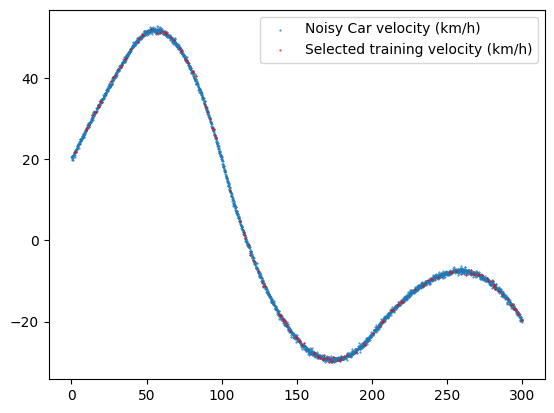

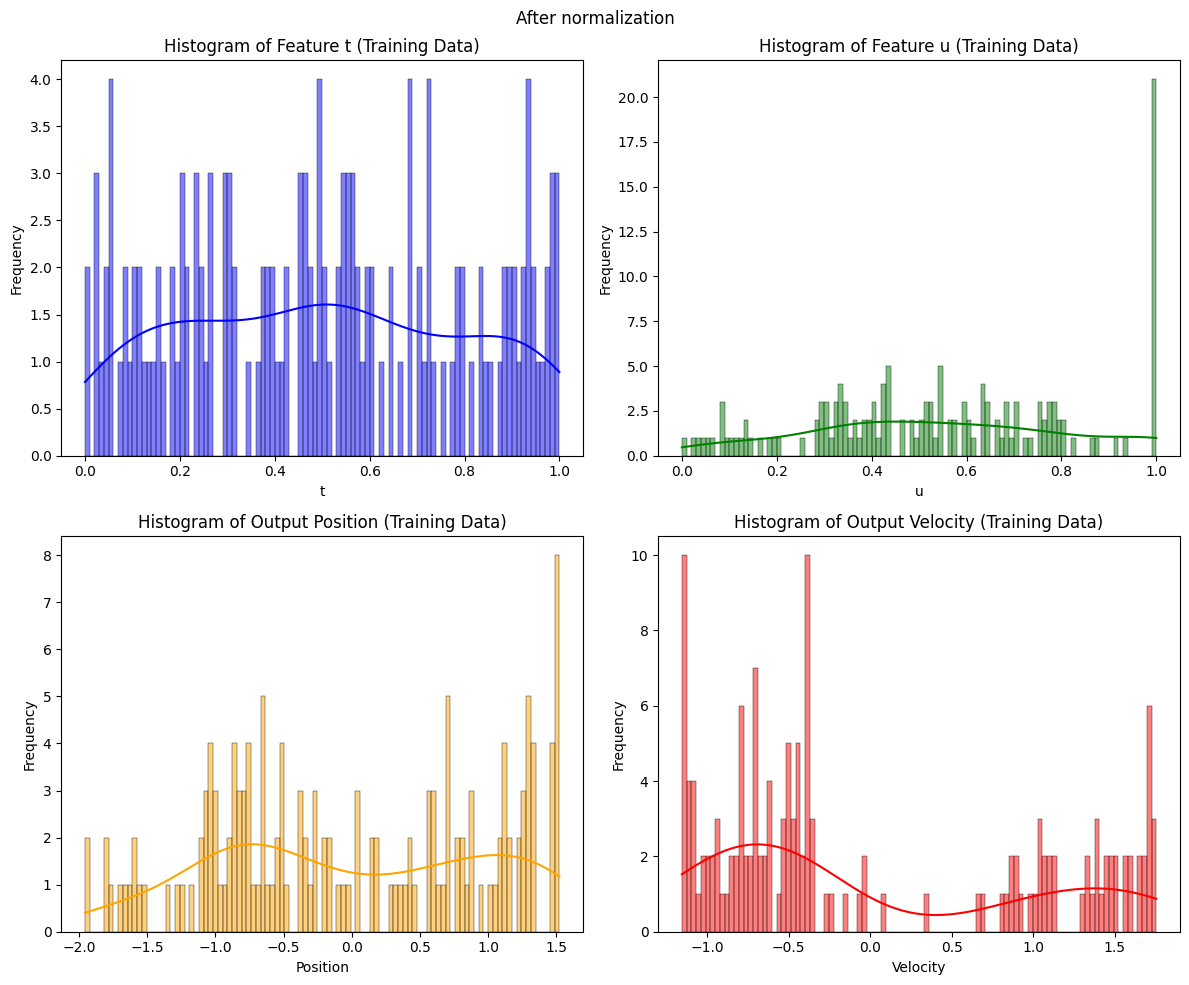

In [11]:
# prepping the data
train_ratio = .05
X = np.stack([t, u(t)], axis=-1) #t and u as features

Y_train, Y_test, X_train, X_test = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise[:, 1] * 3.6, label="Noisy Car velocity (km/h)", s=.2)
plt.scatter(t, Y_mask[:, 1] * 3.6, label="Selected training velocity (km/h)", s=.2, color="red")
plt.legend()
plt.show()

#Prediction Normalization
# if we dont do this, position contributes more to the loss, due to the sheer inbalance of scale
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_test_norm = scaler_Y.transform(Y_test)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :]

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x_0_norm = X_norm[0, :]

# Plot histograms for features and outputs using seaborn
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Histogram of Feature t (Training Data)')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Histogram of Feature u (Training Data)')
axes[0, 1].set_xlabel('u')
axes[0, 1].set_ylabel('Frequency')

# Plot histograms for outputs
sns.histplot(Y_train_norm[:, 0], bins=100, kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Histogram of Output Position (Training Data)')
axes[1, 0].set_xlabel('Position')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(Y_train_norm[:, 1], bins=100, kde=True, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Histogram of Output Velocity (Training Data)')
axes[1, 1].set_xlabel('Velocity')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# PUNN-only

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.9598 - val_loss: 0.7446
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7614 - val_loss: 0.5960
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6687 - val_loss: 0.5472
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5721 - val_loss: 0.5138
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5438 - val_loss: 0.4676
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4598 - val_loss: 0.4208
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4677 - val_loss: 0.3859
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4209 - val_loss: 0.3662
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4114 - val_loss: 0.3408
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.3621 - val_loss: 0.3405
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3646 - val_loss: 0.3307
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

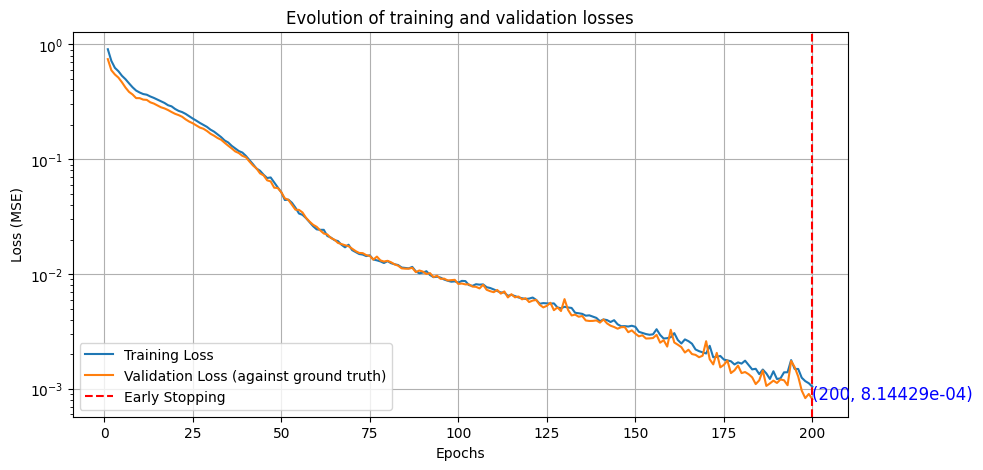

In [12]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 200
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
loss = "mse"
#------

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(2, ))) #input: t,u
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#with output scaling:
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm, Y_true_norm),
                                  batch_size=16, epochs=epochs, verbose=True)
loss_plot(history_punn_fwd.history)

In [13]:
punn_model.save("punn_model_forward.h5")

## PUNN predictions
Very nice for training u but change it and see the model totally fail :-)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Normalized MSE overall: 8.14429e-04
Normalized MSE for position: 3.70893e-04
Normalized MSE for velocity: 1.25796e-03


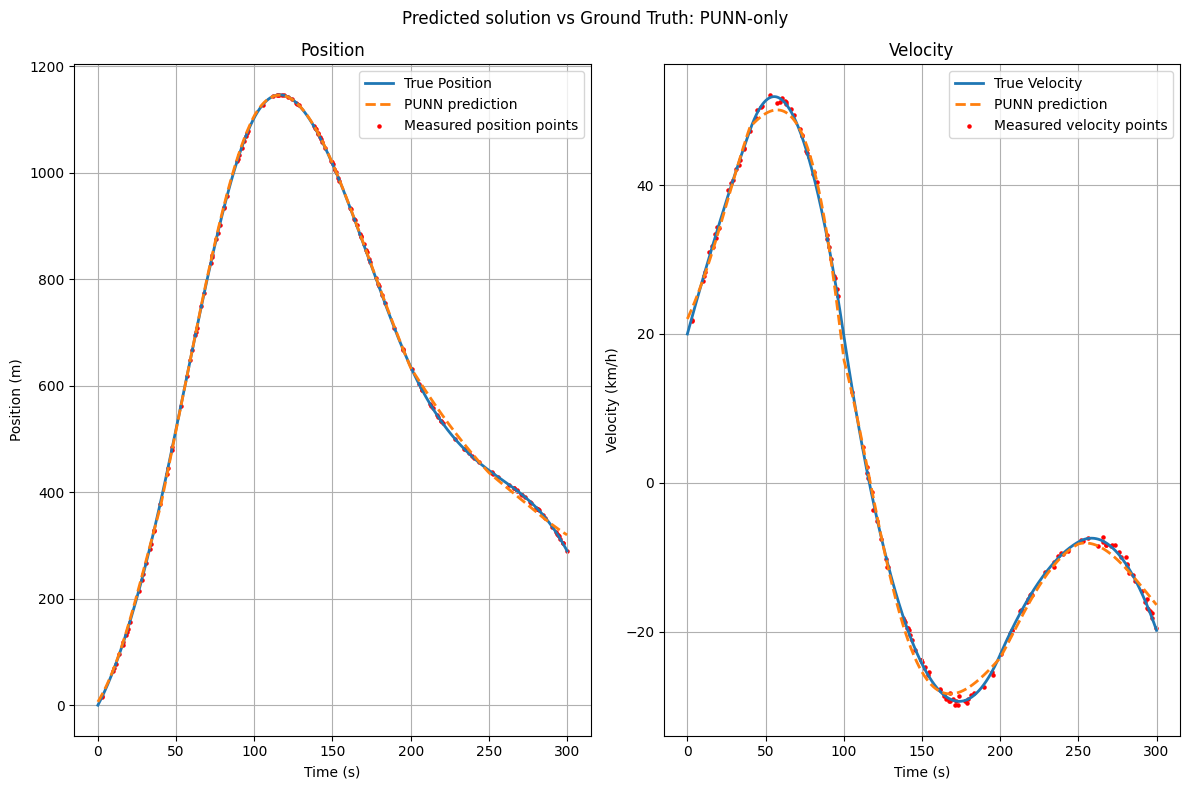

In [14]:
#punn_model = load_model("punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
predictions_norm = punn_model.predict(X_norm)   #predictions shape will be (3000, 2)
mse_total = mean_squared_error(Y_true_norm, predictions_norm)
mse_x = mean_squared_error(Y_true_norm[:, 0], predictions_norm[:, 0])
mse_v = mean_squared_error(Y_true_norm[:, 1], predictions_norm[:, 1])
print(f"Normalized MSE overall: {mse_total:.5e}")
print(f"Normalized MSE for position: {mse_x:.5e}")
print(f"Normalized MSE for velocity: {mse_v:.5e}")

predictions = scaler_Y.inverse_transform(predictions_norm) #denormalize for true trajectories
comparison_plot(t, Y_true, Y_mask, [(predictions, "PUNN prediction")], "Predicted solution vs Ground Truth: PUNN-only")


# PINN

## Combined Loss

In [19]:
collocation_size = 10*X_train_norm.shape[0] #same length as training time instants (for now)
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = u(t_c)
X_c = np.stack([t_c, u_c], axis=-1)
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y_0_norm: np.ndarray, x_0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, scaler_Y, loss_weights: tuple[float, float, float]):
        super().__init__()
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #initial conditions
        self.y_0_norm = y_0_norm
        self.x_0_norm = x_0_norm
        self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        self.X_c_norm = tf.constant(X_c_norm, dtype=tf.float32)
        self.u_phy = self.scaler_X.inverse_transform(self.X_c_norm)[:, 1] #coonvert u to physic units again

    def data_loss(self, y_true, y_pred):
        sqr_diff = keras.ops.square(y_true - y_pred)
        return keras.ops.mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        with tf.GradientTape(persistent=True) as tape: #automatic differentiation
            tape.watch(self.X_c_norm) #record gradients for all time collocation points (normalized)
            #we need the model for prediction since collocation points might not be training points!
            y_norm = self.model(self.X_c_norm)
            y_norm_x = y_norm[:, 0] #need these variables so that the tape keeps track
            y_norm_v = y_norm[:, 1]

        # norm gradients w.r.t normalized inputs
        grad_x_norm = tape.gradient(y_norm_x, self.X_c_norm)  # dx_norm/dX_norm
        grad_v_norm = tape.gradient(y_norm_v, self.X_c_norm)  # dv_norm/dX_norm
        del tape

        y_phy = y_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ # Denormalize (standard scaler)
        x_phy = y_phy[:, 0]
        v_phy = y_phy[:, 1]

         # Time scaling factor from MinMaxScaler, t_norm = t*scale + t_min
        t_scale = self.scaler_X.scale_[0]  # scale = (norm_max-norm_min)/(t_max - t_min)

        # Compute real-time derivatives using the chain rule
        dx_dt = grad_x_norm[:, 0] * t_scale * scaler_Y.scale_[0]  # dx/dt = dx_norm/dt_norm * dt_norm/dt * dx/dx_norm
        dv_dt = grad_v_norm[:, 0] * t_scale * scaler_Y.scale_[1]  # same for dv/dt

        Fr = (car.c0 + car.c1*v_phy)*(car.m*g*np.cos(car.road_grade))
        Fa = (car.p*car.Cd*car.Af*v_phy**2)/2
        Fg = car.m*g*np.sin(car.road_grade)

        res_x = dx_dt-v_phy
        res_v = car.m * dv_dt - (self.u_phy - Fr - Fa - Fg)
        res = keras.ops.stack([res_x, res_v], axis=-1)

        sqr_diff = keras.ops.square(res)
        return keras.ops.mean(sqr_diff)

    def boundary_loss(self):
        y0_pred = self.model(self.x_0_norm[np.newaxis, :]) # add None: batch dimension
        sqr_diff = keras.ops.square(y0_pred - self.y_0_norm)
        return keras.ops.mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return self.alpha_d*data_loss + self.alpha_p*pde_loss + self.alpha_b*bound_loss


## Training

In [ ]:
#globals
#------
n_hid_layers = 3
n_neurons = 50
act = "tanh"
epochs = 2000
patience = 50
metrics = []
opt = Adam(learning_rate=0.001, weight_decay=0.01)
alpha_d = 1
alpha_p = 5
alpha_b = 5
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(2, ))) #input: t and u
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(2, activation="linear")) #output layer -> p^ and v^
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=scaler_Y, loss_weights=alpha, x_0_norm=x_0_norm, y_0_norm=y_0_norm)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
def lr_schedule(epoch, lr):
    if (epoch+1) % 250 == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='pinn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train_norm, validation_data=(X_norm,Y_true_norm),
                                  batch_size=16, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_pinn_fwd.history)

Epoch 1/2000
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 158814.8750

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 158079.7344 - val_loss: 151920.8750 - learning_rate: 0.0010
Epoch 2/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 146779.0625 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 146234.7344 - val_loss: 116487.3047 - learning_rate: 0.0010
Epoch 3/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 104075.3828 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 103134.5781 - val_loss: 70432.6094 - learning_rate: 0.0010
Epoch 4/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68039.2578 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 67972.0391 - val_loss: 68260.4062 - learning_rate: 0.0010
Epoch 5/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66462.6641 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 66299.4219 - val_loss: 61042.5469 - learning_rate: 0.0010
Epoch 6/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 61042.5781

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 60867.1914 - val_loss: 58876.9805 - learning_rate: 0.0010
Epoch 7/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57966.6133 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 57893.1641 - val_loss: 54898.0938 - learning_rate: 0.0010
Epoch 8/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 53922.0742 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 53836.6250 - val_loss: 50084.6719 - learning_rate: 0.0010
Epoch 9/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48927.9492 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 48831.4219 - val_loss: 44617.6914 - learning_rate: 0.0010
Epoch 10/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43318.5234 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 43214.2539 - val_loss: 38877.1914 - learning_rate: 0.0010
Epoch 11/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37694.4570 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 37601.4062 - val_loss: 33829.1172 - learning_rate: 0.0010
Epoch 12/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32863.5547 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 32787.7852 - val_loss: 29716.1699 - learning_rate: 0.0010
Epoch 13/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28912.2676 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 28848.2812 - val_loss: 26199.3203 - learning_rate: 0.0010
Epoch 14/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25456.1719 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 25396.1582 - val_loss: 22868.6113 - learning_rate: 0.0010
Epoch 15/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22125.2324 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 22064.5664 - val_loss: 19475.0781 - learning_rate: 0.0010
Epoch 16/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18684.6797 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 18619.7773 - val_loss: 15834.6748 - learning_rate: 0.0010
Epoch 17/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14984.9551 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 14915.6045 - val_loss: 11975.2354 - learning_rate: 0.0010
Epoch 18/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11130.2168 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 11062.9160 - val_loss: 8314.1768 - learning_rate: 0.0010
Epoch 19/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7640.3628 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 7589.4492 - val_loss: 5656.1650 - learning_rate: 0.0010
Epoch 20/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5295.2544 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5269.7358 - val_loss: 4367.6094 - learning_rate: 0.0010
Epoch 21/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4222.4111 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4211.7544 - val_loss: 3804.5842 - learning_rate: 0.0010
Epoch 22/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3706.5488 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3698.8086 - val_loss: 3385.3984 - learning_rate: 0.0010
Epoch 23/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3384.9724

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3303.3843 - val_loss: 3077.2688 - learning_rate: 0.0010
Epoch 24/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3025.0708 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3021.0261 - val_loss: 2858.4709 - learning_rate: 0.0010
Epoch 25/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2816.5706 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2813.2964 - val_loss: 2678.6892 - learning_rate: 0.0010
Epoch 26/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2643.1426 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2640.2786 - val_loss: 2523.1431 - learning_rate: 0.0010
Epoch 27/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2491.5632 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2489.0332 - val_loss: 2384.3560 - learning_rate: 0.0010
Epoch 28/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2383.7673

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2353.2815 - val_loss: 2256.9468 - learning_rate: 0.0010
Epoch 29/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2258.3311

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2228.1755 - val_loss: 2138.1101 - learning_rate: 0.0010
Epoch 30/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2137.2214

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 2110.5923 - val_loss: 2026.1287 - learning_rate: 0.0010
Epoch 31/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2002.2511 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2000.3291 - val_loss: 1919.8230 - learning_rate: 0.0010
Epoch 32/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1897.3967 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1895.5370 - val_loss: 1818.4720 - learning_rate: 0.0010
Epoch 33/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1796.5673 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1794.8379 - val_loss: 1721.6890 - learning_rate: 0.0010
Epoch 34/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1721.9528

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1699.2390 - val_loss: 1629.3094 - learning_rate: 0.0010
Epoch 35/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1609.3425 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1607.7740 - val_loss: 1541.3234 - learning_rate: 0.0010
Epoch 36/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1540.4841

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1520.8408 - val_loss: 1457.7826 - learning_rate: 0.0010
Epoch 37/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1459.1407

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1438.5876 - val_loss: 1378.7570 - learning_rate: 0.0010
Epoch 38/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1377.1085

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1360.4386 - val_loss: 1304.2374 - learning_rate: 0.0010
Epoch 39/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1289.1504 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1287.8230 - val_loss: 1234.2087 - learning_rate: 0.0010
Epoch 40/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1235.3422

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1218.6613 - val_loss: 1168.5510 - learning_rate: 0.0010
Epoch 41/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1170.3325

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1154.0110 - val_loss: 1107.1603 - learning_rate: 0.0010
Epoch 42/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1108.6663

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1093.4814 - val_loss: 1049.8608 - learning_rate: 0.0010
Epoch 43/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1050.7139

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1037.0955 - val_loss: 996.4539 - learning_rate: 0.0010
Epoch 44/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 985.7664 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 984.8188 - val_loss: 946.7258 - learning_rate: 0.0010
Epoch 45/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 945.6260

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 935.0864 - val_loss: 900.4287 - learning_rate: 0.0010
Epoch 46/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 900.1395

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 889.5461 - val_loss: 857.3412 - learning_rate: 0.0010
Epoch 47/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 861.5145

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 848.1846 - val_loss: 817.2571 - learning_rate: 0.0010
Epoch 48/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 818.1260

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 807.9976 - val_loss: 779.9684 - learning_rate: 0.0010
Epoch 49/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 776.8073

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 771.1725 - val_loss: 745.3221 - learning_rate: 0.0010
Epoch 50/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 744.2476

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 737.1385 - val_loss: 713.1553 - learning_rate: 0.0010
Epoch 51/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 719.2946

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 707.3728 - val_loss: 683.3591 - learning_rate: 0.0010
Epoch 52/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 685.0573

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 677.0337 - val_loss: 655.7738 - learning_rate: 0.0010
Epoch 53/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 656.9551

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 649.5341 - val_loss: 630.3127 - learning_rate: 0.0010
Epoch 54/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 631.7664

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 624.5302 - val_loss: 606.8494 - learning_rate: 0.0010
Epoch 55/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 605.4515

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 600.6936 - val_loss: 585.2664 - learning_rate: 0.0010
Epoch 56/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 585.3094

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 580.2528 - val_loss: 565.4412 - learning_rate: 0.0010
Epoch 57/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 560.8941 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 560.5869 - val_loss: 547.2396 - learning_rate: 0.0010
Epoch 58/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 549.5885

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 543.5364 - val_loss: 530.5126 - learning_rate: 0.0010
Epoch 59/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 533.0121

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 526.8477 - val_loss: 515.1096 - learning_rate: 0.0010
Epoch 60/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 514.9706

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 510.7563 - val_loss: 500.9017 - learning_rate: 0.0010
Epoch 61/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 497.5254 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 497.2993 - val_loss: 487.7543 - learning_rate: 0.0010
Epoch 62/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 484.1853 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 484.0109 - val_loss: 475.5319 - learning_rate: 0.0010
Epoch 63/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 472.2679 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 472.0944 - val_loss: 464.1082 - learning_rate: 0.0010
Epoch 64/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 461.4391 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 461.2357 - val_loss: 453.3804 - learning_rate: 0.0010
Epoch 65/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 456.4269

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 451.1526 - val_loss: 443.2471 - learning_rate: 0.0010
Epoch 66/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 440.0345 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 439.9188 - val_loss: 433.6284 - learning_rate: 0.0010
Epoch 67/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 437.4524

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 432.3793 - val_loss: 424.4524 - learning_rate: 0.0010
Epoch 68/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 417.0882

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 420.8899 - val_loss: 415.6464 - learning_rate: 0.0010
Epoch 69/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 414.3617

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 413.3920 - val_loss: 407.1638 - learning_rate: 0.0010
Epoch 70/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 408.1293

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 404.4448 - val_loss: 398.9630 - learning_rate: 0.0010
Epoch 71/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 399.1147

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 396.4373 - val_loss: 390.9927 - learning_rate: 0.0010
Epoch 72/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 389.1232

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 388.6926 - val_loss: 383.2191 - learning_rate: 0.0010
Epoch 73/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 387.6180

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 381.7032 - val_loss: 375.6158 - learning_rate: 0.0010
Epoch 74/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 374.5455 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 374.2950 - val_loss: 368.1483 - learning_rate: 0.0010
Epoch 75/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 364.0317 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 364.0594 - val_loss: 360.7932 - learning_rate: 0.0010
Epoch 76/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 359.5222 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 359.2918 - val_loss: 353.5532 - learning_rate: 0.0010
Epoch 77/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 354.6605

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 350.8415 - val_loss: 346.3956 - learning_rate: 0.0010
Epoch 78/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 348.3394

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 344.1917 - val_loss: 339.3311 - learning_rate: 0.0010
Epoch 79/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 333.9800

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 335.9083 - val_loss: 332.3023 - learning_rate: 0.0010
Epoch 80/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 328.7610

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 328.7643 - val_loss: 325.3400 - learning_rate: 0.0010
Epoch 81/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 328.6772

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 323.5957 - val_loss: 318.4258 - learning_rate: 0.0010
Epoch 82/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 313.0366

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 314.1562 - val_loss: 311.5575 - learning_rate: 0.0010
Epoch 83/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 304.3557

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 308.5898 - val_loss: 304.7432 - learning_rate: 0.0010
Epoch 84/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 301.9031

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 302.0568 - val_loss: 297.9374 - learning_rate: 0.0010
Epoch 85/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 296.3583 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 296.1451 - val_loss: 291.1758 - learning_rate: 0.0010
Epoch 86/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 290.2790

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 288.3383 - val_loss: 284.4560 - learning_rate: 0.0010
Epoch 87/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 281.7323

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 280.8979 - val_loss: 277.7697 - learning_rate: 0.0010
Epoch 88/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 272.8848

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 273.8962 - val_loss: 271.1497 - learning_rate: 0.0010
Epoch 89/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 274.4186

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 268.8381 - val_loss: 264.5600 - learning_rate: 0.0010
Epoch 90/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 259.3362

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 262.1413 - val_loss: 258.0400 - learning_rate: 0.0010
Epoch 91/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 259.4728

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 255.6399 - val_loss: 252.6281 - learning_rate: 0.0010
Epoch 92/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 248.1009 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 248.0754 - val_loss: 245.2453 - learning_rate: 0.0010
Epoch 93/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 241.2200

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 241.9824 - val_loss: 238.7557 - learning_rate: 0.0010
Epoch 94/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 234.6891

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 236.0969 - val_loss: 232.4599 - learning_rate: 0.0010
Epoch 95/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 228.8773 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 228.8298 - val_loss: 226.2413 - learning_rate: 0.0010
Epoch 96/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 222.7410

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 222.3730 - val_loss: 220.1468 - learning_rate: 0.0010
Epoch 97/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 221.3157

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 217.8397 - val_loss: 214.0927 - learning_rate: 0.0010
Epoch 98/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 210.8166

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 211.1126 - val_loss: 208.2629 - learning_rate: 0.0010
Epoch 99/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 214.6922

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 206.6195 - val_loss: 202.5504 - learning_rate: 0.0010
Epoch 100/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 203.1823

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 200.3394 - val_loss: 197.7133 - learning_rate: 0.0010
Epoch 101/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 194.2431

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 194.2976 - val_loss: 191.0937 - learning_rate: 0.0010
Epoch 102/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 187.8378

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 186.7977 - val_loss: 185.5631 - learning_rate: 0.0010
Epoch 103/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 182.5765

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 181.9534 - val_loss: 180.2808 - learning_rate: 0.0010
Epoch 104/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 180.2222

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 177.7380 - val_loss: 174.9823 - learning_rate: 0.0010
Epoch 105/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 165.8002

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 170.5635 - val_loss: 170.0011 - learning_rate: 0.0010
Epoch 106/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 172.8233

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 167.9842 - val_loss: 167.0931 - learning_rate: 0.0010
Epoch 107/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 169.3550

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 166.1266 - val_loss: 160.6899 - learning_rate: 0.0010
Epoch 108/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 157.7881

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 157.7060 - val_loss: 156.4702 - learning_rate: 0.0010
Epoch 109/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 153.1793 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 153.1027 - val_loss: 152.1183 - learning_rate: 0.0010
Epoch 110/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 150.2351 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 150.0317 - val_loss: 147.8419 - learning_rate: 0.0010
Epoch 111/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 144.4790 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 144.4245 - val_loss: 143.7454 - learning_rate: 0.0010
Epoch 112/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 139.6436 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 139.6740 - val_loss: 139.7985 - learning_rate: 0.0010
Epoch 113/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 139.4397

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 137.3727 - val_loss: 136.2192 - learning_rate: 0.0010
Epoch 114/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 135.6571

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 132.9251 - val_loss: 132.8188 - learning_rate: 0.0010
Epoch 115/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 127.3181

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 128.3233 - val_loss: 130.2168 - learning_rate: 0.0010
Epoch 116/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 129.4552 - val_loss: 131.3307 - learning_rate: 0.0010
Epoch 117/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 125.4337

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 125.5728 - val_loss: 124.9410 - learning_rate: 0.0010
Epoch 118/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 123.5727

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 120.8537 - val_loss: 121.3892 - learning_rate: 0.0010
Epoch 119/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 122.7591

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 119.3240 - val_loss: 118.5685 - learning_rate: 0.0010
Epoch 120/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 119.9068

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 117.7341 - val_loss: 116.1846 - learning_rate: 0.0010
Epoch 121/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 114.3578

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 113.4775 - val_loss: 113.9471 - learning_rate: 0.0010
Epoch 122/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 110.9380

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 110.6528 - val_loss: 112.3482 - learning_rate: 0.0010
Epoch 123/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 110.7856 - val_loss: 112.7844 - learning_rate: 0.0010
Epoch 124/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 106.1068

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 108.5094 - val_loss: 108.1939 - learning_rate: 0.0010
Epoch 125/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 114.7999

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 108.4069 - val_loss: 107.3924 - learning_rate: 0.0010
Epoch 126/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 113.0503

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 106.0572 - val_loss: 104.9099 - learning_rate: 0.0010
Epoch 127/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 102.5040

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 102.4363 - val_loss: 103.5085 - learning_rate: 0.0010
Epoch 128/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 103.6849 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 103.3861 - val_loss: 102.3038 - learning_rate: 0.0010
Epoch 129/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 102.0447 - val_loss: 109.5995 - learning_rate: 0.0010
Epoch 130/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 107.6874 - val_loss: 103.7878 - learning_rate: 0.0010
Epoch 131/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 99.9797

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 98.9378 - val_loss: 99.6033 - learning_rate: 0.0010
Epoch 132/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 97.7514 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 97.5927 - val_loss: 97.4059 - learning_rate: 0.0010
Epoch 133/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 94.6945 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 94.6731 - val_loss: 96.3658 - learning_rate: 0.0010
Epoch 134/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 92.0942

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 94.0588 - val_loss: 95.4759 - learning_rate: 0.0010
Epoch 135/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 95.6671 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 95.3688 - val_loss: 94.5037 - learning_rate: 0.0010
Epoch 136/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 92.0723 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 92.0174 - val_loss: 93.6404 - learning_rate: 0.0010
Epoch 137/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 90.2271 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 90.2826 - val_loss: 93.1617 - learning_rate: 0.0010
Epoch 138/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 89.8307

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 90.1754 - val_loss: 92.0683 - learning_rate: 0.0010
Epoch 139/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 91.7984 - val_loss: 96.1329 - learning_rate: 0.0010
Epoch 140/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 88.6686

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 90.6222 - val_loss: 90.8853 - learning_rate: 0.0010
Epoch 141/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 91.3073

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 88.5218 - val_loss: 90.0547 - learning_rate: 0.0010
Epoch 142/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 85.0703 - val_loss: 90.5568 - learning_rate: 0.0010
Epoch 143/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 92.7373

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 87.6672 - val_loss: 88.5936 - learning_rate: 0.0010
Epoch 144/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 83.9515

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 86.3702 - val_loss: 87.8072 - learning_rate: 0.0010
Epoch 145/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 84.4062

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 83.8519 - val_loss: 87.1635 - learning_rate: 0.0010
Epoch 146/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 80.4218

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 83.7803 - val_loss: 86.5805 - learning_rate: 0.0010
Epoch 147/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 84.6980 - val_loss: 96.3002 - learning_rate: 0.0010
Epoch 148/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 96.1942 - val_loss: 90.5481 - learning_rate: 0.0010
Epoch 149/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 85.9464 - val_loss: 87.3316 - learning_rate: 0.0010
Epoch 150/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 82.1101

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 82.7844 - val_loss: 84.3327 - learning_rate: 0.0010
Epoch 151/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 84.1505 - val_loss: 84.3707 - learning_rate: 0.0010
Epoch 152/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 92.6082

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 81.9107 - val_loss: 83.1022 - learning_rate: 0.0010
Epoch 153/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 75.2664

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 78.8910 - val_loss: 82.6469 - learning_rate: 0.0010
Epoch 154/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77.8581 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 78.0166 - val_loss: 82.0486 - learning_rate: 0.0010
Epoch 155/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 78.9490

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 79.0686 - val_loss: 81.4870 - learning_rate: 0.0010
Epoch 156/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 82.3510

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 79.8962 - val_loss: 80.9818 - learning_rate: 0.0010
Epoch 157/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 77.9211 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 77.9330 - val_loss: 80.7046 - learning_rate: 0.0010
Epoch 158/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 67.1859

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 76.0581 - val_loss: 80.1221 - learning_rate: 0.0010
Epoch 159/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 77.6687 - val_loss: 80.5354 - learning_rate: 0.0010
Epoch 160/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 80.6673 - val_loss: 80.5428 - learning_rate: 0.0010
Epoch 161/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 70.7319

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 74.5623 - val_loss: 79.0346 - learning_rate: 0.0010
Epoch 162/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 79.8742

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 77.4336 - val_loss: 77.9470 - learning_rate: 0.0010
Epoch 163/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 76.6914 - val_loss: 81.8386 - learning_rate: 0.0010
Epoch 164/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 82.4479 - val_loss: 79.2757 - learning_rate: 0.0010
Epoch 165/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76.3108 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 76.2765 - val_loss: 77.7921 - learning_rate: 0.0010
Epoch 166/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 74.5426

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 74.5231 - val_loss: 76.6344 - learning_rate: 0.0010
Epoch 167/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 72.7700

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 73.9659 - val_loss: 75.6098 - learning_rate: 0.0010
Epoch 168/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 75.7518 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 75.4707 - val_loss: 75.2046 - learning_rate: 0.0010
Epoch 169/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 79.3270

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 73.5894 - val_loss: 74.7294 - learning_rate: 0.0010
Epoch 170/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 73.0953 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 72.9759 - val_loss: 74.3313 - learning_rate: 0.0010
Epoch 171/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 69.9956

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 71.5079 - val_loss: 74.2410 - learning_rate: 0.0010
Epoch 172/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 72.9981 - val_loss: 84.6191 - learning_rate: 0.0010
Epoch 173/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 87.4056 - val_loss: 74.3148 - learning_rate: 0.0010
Epoch 174/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 78.2459 - val_loss: 76.9824 - learning_rate: 0.0010
Epoch 175/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 75.5074

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 72.3787 - val_loss: 72.7440 - learning_rate: 0.0010
Epoch 176/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 68.9654

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 68.7993 - val_loss: 71.9105 - learning_rate: 0.0010
Epoch 177/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 71.1205

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 69.3951 - val_loss: 71.7992 - learning_rate: 0.0010
Epoch 178/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 72.8951

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 69.2076 - val_loss: 71.2326 - learning_rate: 0.0010
Epoch 179/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 67.2789

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 68.1522 - val_loss: 70.8873 - learning_rate: 0.0010
Epoch 180/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 75.2542

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 69.3054 - val_loss: 70.4904 - learning_rate: 0.0010
Epoch 181/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 68.2480

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 66.7245 - val_loss: 69.9458 - learning_rate: 0.0010
Epoch 182/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 66.1722 - val_loss: 71.1438 - learning_rate: 0.0010
Epoch 183/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 73.1300

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 68.8030 - val_loss: 69.3712 - learning_rate: 0.0010
Epoch 184/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 67.9348 - val_loss: 70.4615 - learning_rate: 0.0010
Epoch 185/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 66.7655 - val_loss: 70.6261 - learning_rate: 0.0010
Epoch 186/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 57.2514

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 64.8525 - val_loss: 68.3932 - learning_rate: 0.0010
Epoch 187/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 65.7795 - val_loss: 69.7985 - learning_rate: 0.0010
Epoch 188/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 68.1716 - val_loss: 73.3797 - learning_rate: 0.0010
Epoch 189/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 68.5971 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 68.4585 - val_loss: 67.4961 - learning_rate: 0.0010
Epoch 190/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 66.4771 - val_loss: 69.0466 - learning_rate: 0.0010
Epoch 191/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 59.3907

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 64.4142 - val_loss: 66.7526 - learning_rate: 0.0010
Epoch 192/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 64.6880

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 63.6881 - val_loss: 66.6403 - learning_rate: 0.0010
Epoch 193/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 63.0127 - val_loss: 67.1506 - learning_rate: 0.0010
Epoch 194/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 64.7836 - val_loss: 70.5499 - learning_rate: 0.0010
Epoch 195/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 68.4568 - val_loss: 67.6652 - learning_rate: 0.0010
Epoch 196/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 65.5826 - val_loss: 67.5696 - learning_rate: 0.0010
Epoch 197/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 58.1886

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 63.3858 - val_loss: 64.9168 - learning_rate: 0.0010
Epoch 198/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 62.1217 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 62.0967 - val_loss: 64.4608 - learning_rate: 0.0010
Epoch 199/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 62.8042 - val_loss: 64.9696 - learning_rate: 0.0010
Epoch 200/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 64.0899 - val_loss: 71.4119 - learning_rate: 0.0010
Epoch 201/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 69.6519

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 67.1910 - val_loss: 63.6303 - learning_rate: 0.0010
Epoch 202/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 61.3255 - val_loss: 64.0042 - learning_rate: 0.0010
Epoch 203/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 55.9458

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 60.0291 - val_loss: 63.0980 - learning_rate: 0.0010
Epoch 204/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 61.3113

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 60.1571 - val_loss: 63.0390 - learning_rate: 0.0010
Epoch 205/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57.6867 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 57.9027 - val_loss: 62.5734 - learning_rate: 0.0010
Epoch 206/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 60.5034 - val_loss: 68.3738 - learning_rate: 0.0010
Epoch 207/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 74.4463 - val_loss: 68.8268 - learning_rate: 0.0010
Epoch 208/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 64.9600 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 64.9135 - val_loss: 62.0073 - learning_rate: 0.0010
Epoch 209/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 59.5259 - val_loss: 62.1925 - learning_rate: 0.0010
Epoch 210/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 52.6862

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 58.9807 - val_loss: 61.9718 - learning_rate: 0.0010
Epoch 211/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 55.6315

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 59.4265 - val_loss: 61.4400 - learning_rate: 0.0010
Epoch 212/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 54.5642

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 57.3653 - val_loss: 61.0426 - learning_rate: 0.0010
Epoch 213/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 52.9134

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 56.6557 - val_loss: 60.6501 - learning_rate: 0.0010
Epoch 214/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 55.0827

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 56.7867 - val_loss: 60.4745 - learning_rate: 0.0010
Epoch 215/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 60.3709

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 56.9661 - val_loss: 60.2734 - learning_rate: 0.0010
Epoch 216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 57.7449 - val_loss: 60.6791 - learning_rate: 0.0010
Epoch 217/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 55.6964 - val_loss: 60.4850 - learning_rate: 0.0010
Epoch 218/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 57.3481 - val_loss: 61.6295 - learning_rate: 0.0010
Epoch 219/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 60.7038 - val_loss: 69.7364 - learning_rate: 0.0010
Epoch 220/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 61.3294

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 67.0556 - val_loss: 59.1479 - learning_rate: 0.0010
Epoch 221/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 55.8738 - val_loss: 59.8902 - learning_rate: 0.0010
Epoch 222/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 55.4070 - val_loss: 59.4878 - learning_rate: 0.0010
Epoch 223/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 55.5956 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 55.6405 - val_loss: 58.9905 - learning_rate: 0.0010
Epoch 224/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 50.7751

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 54.0842 - val_loss: 58.3260 - learning_rate: 0.0010
Epoch 225/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 55.0142 - val_loss: 58.6601 - learning_rate: 0.0010
Epoch 226/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 56.2571 - val_loss: 63.0145 - learning_rate: 0.0010
Epoch 227/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 63.7337 - val_loss: 62.2066 - learning_rate: 0.0010
Epoch 228/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 58.6078 - val_loss: 60.2271 - learning_rate: 0.0010
Epoch 229/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 60.6621

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 55.4067 - val_loss: 57.3865 - learning_rate: 0.0010
Epoch 230/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 53.0466

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 54.4076 - val_loss: 57.1502 - learning_rate: 0.0010
Epoch 231/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 51.6804

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 54.0952 - val_loss: 56.9590 - learning_rate: 0.0010
Epoch 232/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 54.8346 - val_loss: 57.3716 - learning_rate: 0.0010
Epoch 233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 57.3871 - val_loss: 61.9251 - learning_rate: 0.0010
Epoch 234/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 61.8944 - val_loss: 64.2589 - learning_rate: 0.0010
Epoch 235/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 56.5102 - val_loss: 59.7627 - learning_rate: 0.0010
Epoch 236/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 55.8255 - val_loss: 58.2304 - learning_rate: 0.0010
Epoch 237/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 54.1043 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 54.1289 - val_loss: 56.1025 - learning_rate: 0.0010
Epoch 238/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.9646 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 51.2559 - val_loss: 55.8797 - learning_rate: 0.0010
Epoch 239/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 53.0195 - val_loss: 56.2545 - learning_rate: 0.0010
Epoch 240/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.2331 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 52.2848 - val_loss: 55.2552 - learning_rate: 0.0010
Epoch 241/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 53.1341 - val_loss: 56.4623 - learning_rate: 0.0010
Epoch 242/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 55.5971 - val_loss: 59.9416 - learning_rate: 0.0010
Epoch 243/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 59.2694 - val_loss: 61.1160 - learning_rate: 0.0010
Epoch 244/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 55.2483 - val_loss: 59.2135 - learning_rate: 0.0010
Epoch 245/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56.2954 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 56.1557 - val_loss: 54.4619 - learning_rate: 0.0010
Epoch 246/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 55.2196 - val_loss: 54.9275 - learning_rate: 0.0010
Epoch 247/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 50.9630 - val_loss: 54.9830 - learning_rate: 0.0010
Epoch 248/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 56.0069

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 52.8653 - val_loss: 53.8480 - learning_rate: 0.0010
Epoch 249/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 51.8367 - val_loss: 54.2419 - learning_rate: 0.0010
Epoch 250/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 51.0425

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 51.1409 - val_loss: 53.6801 - learning_rate: 9.0000e-04
Epoch 251/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 55.0304

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 51.5957 - val_loss: 53.4062 - learning_rate: 9.0000e-04
Epoch 252/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 51.2863

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 51.7976 - val_loss: 53.2291 - learning_rate: 9.0000e-04
Epoch 253/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 50.6884

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 50.7181 - val_loss: 53.0842 - learning_rate: 9.0000e-04
Epoch 254/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 47.0739

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 50.1693 - val_loss: 52.9418 - learning_rate: 9.0000e-04
Epoch 255/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 57.8045

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 52.0097 - val_loss: 52.9054 - learning_rate: 9.0000e-04
Epoch 256/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 44.7763

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 49.8284 - val_loss: 52.6495 - learning_rate: 9.0000e-04
Epoch 257/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 49.2654

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 50.0182 - val_loss: 52.6487 - learning_rate: 9.0000e-04
Epoch 258/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 49.9385

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 50.3119 - val_loss: 52.3975 - learning_rate: 9.0000e-04
Epoch 259/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 56.3058

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 51.3055 - val_loss: 52.1954 - learning_rate: 9.0000e-04
Epoch 260/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 49.3650

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 49.5109 - val_loss: 52.1085 - learning_rate: 9.0000e-04
Epoch 261/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 44.3722

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 49.1053 - val_loss: 51.9568 - learning_rate: 9.0000e-04
Epoch 262/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 53.2414

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 49.6871 - val_loss: 51.8745 - learning_rate: 9.0000e-04
Epoch 263/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 49.8500

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 49.9342 - val_loss: 51.6287 - learning_rate: 9.0000e-04
Epoch 264/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 54.0529

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 49.5576 - val_loss: 51.4834 - learning_rate: 9.0000e-04
Epoch 265/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 49.1247

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 48.3127 - val_loss: 51.4192 - learning_rate: 9.0000e-04
Epoch 266/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 43.1861

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 47.5759 - val_loss: 51.2445 - learning_rate: 9.0000e-04
Epoch 267/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 48.7751 - val_loss: 51.3679 - learning_rate: 9.0000e-04
Epoch 268/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 44.4132

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 47.8084 - val_loss: 50.9526 - learning_rate: 9.0000e-04
Epoch 269/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 46.9789

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 47.8998 - val_loss: 50.8385 - learning_rate: 9.0000e-04
Epoch 270/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 47.6626 - val_loss: 50.8902 - learning_rate: 9.0000e-04
Epoch 271/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 48.1376 - val_loss: 54.4602 - learning_rate: 9.0000e-04
Epoch 272/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 56.2707 - val_loss: 64.6233 - learning_rate: 9.0000e-04
Epoch 273/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 54.0058 - val_loss: 53.3913 - learning_rate: 9.0000e-04
Epoch 274/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.3929 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 52.1906 - val_loss: 50.2577 - learning_rate: 9.0000e-04
Epoch 275/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 47.0118 - val_loss: 50.4223 - learning_rate: 9.0000e-04
Epoch 276/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 50.9290 - val_loss: 50.3437 - learning_rate: 9.0000e-04
Epoch 277/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47.9571 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 47.8995 - val_loss: 50.0299 - learning_rate: 9.0000e-04
Epoch 278/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 47.8187

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 47.6176 - val_loss: 49.7593 - learning_rate: 9.0000e-04
Epoch 279/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 52.8157

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 48.1616 - val_loss: 49.5695 - learning_rate: 9.0000e-04
Epoch 280/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 52.3828

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 48.6313 - val_loss: 49.3222 - learning_rate: 9.0000e-04
Epoch 281/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.9995 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 46.9915 - val_loss: 49.2282 - learning_rate: 9.0000e-04
Epoch 282/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 46.5548 - val_loss: 49.8037 - learning_rate: 9.0000e-04
Epoch 283/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 42.7884

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 46.7964 - val_loss: 49.0167 - learning_rate: 9.0000e-04
Epoch 284/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 46.0116 - val_loss: 49.6277 - learning_rate: 9.0000e-04
Epoch 285/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 46.4815 - val_loss: 55.4362 - learning_rate: 9.0000e-04
Epoch 286/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 53.6640 - val_loss: 50.2444 - learning_rate: 9.0000e-04
Epoch 287/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 46.3179 - val_loss: 51.3887 - learning_rate: 9.0000e-04
Epoch 288/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 48.5256 - val_loss: 49.4721 - learning_rate: 9.0000e-04
Epoch 289/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 45.0373 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 45.1877 - val_loss: 48.5714 - learning_rate: 9.0000e-04
Epoch 290/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 46.2737 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 46.2092 - val_loss: 48.0364 - learning_rate: 9.0000e-04
Epoch 291/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 45.8150 - val_loss: 48.1939 - learning_rate: 9.0000e-04
Epoch 292/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 46.6199 - val_loss: 49.4458 - learning_rate: 9.0000e-04
Epoch 293/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 46.4966 - val_loss: 52.8358 - learning_rate: 9.0000e-04
Epoch 294/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 51.1930 - val_loss: 49.3577 - learning_rate: 9.0000e-04
Epoch 295/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 43.8173 - val_loss: 48.8806 - learning_rate: 9.0000e-04
Epoch 296/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 39.3501

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 44.9805 - val_loss: 47.3316 - learning_rate: 9.0000e-04
Epoch 297/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 44.0597 - val_loss: 49.0900 - learning_rate: 9.0000e-04
Epoch 298/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 45.5187 - val_loss: 49.8853 - learning_rate: 9.0000e-04
Epoch 299/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 40.3995

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 44.4101 - val_loss: 47.3072 - learning_rate: 9.0000e-04
Epoch 300/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.7848 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 44.7437 - val_loss: 46.9691 - learning_rate: 9.0000e-04
Epoch 301/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 43.0741 - val_loss: 49.8905 - learning_rate: 9.0000e-04
Epoch 302/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 48.9970 - val_loss: 52.7505 - learning_rate: 9.0000e-04
Epoch 303/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 48.7922 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 48.6969 - val_loss: 46.6352 - learning_rate: 9.0000e-04
Epoch 304/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.4088 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 43.4474 - val_loss: 46.3524 - learning_rate: 9.0000e-04
Epoch 305/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 44.3609 - val_loss: 46.9221 - learning_rate: 9.0000e-04
Epoch 306/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 42.7603 - val_loss: 47.7368 - learning_rate: 9.0000e-04
Epoch 307/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 45.6459 - val_loss: 50.9897 - learning_rate: 9.0000e-04
Epoch 308/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 49.1686 - val_loss: 49.8372 - learning_rate: 9.0000e-04
Epoch 309/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 44.5008

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 45.4958 - val_loss: 46.1800 - learning_rate: 9.0000e-04
Epoch 310/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 48.3362

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 44.0190 - val_loss: 45.6934 - learning_rate: 9.0000e-04
Epoch 311/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 42.6154 - val_loss: 45.8015 - learning_rate: 9.0000e-04
Epoch 312/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 42.3741 - val_loss: 46.5491 - learning_rate: 9.0000e-04
Epoch 313/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 43.4588 - val_loss: 52.6987 - learning_rate: 9.0000e-04
Epoch 314/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 49.0288 - val_loss: 47.3844 - learning_rate: 9.0000e-04
Epoch 315/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 47.7287

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 44.8017 - val_loss: 45.1131 - learning_rate: 9.0000e-04
Epoch 316/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 42.7440 - val_loss: 45.1235 - learning_rate: 9.0000e-04
Epoch 317/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 43.8797 - val_loss: 45.8426 - learning_rate: 9.0000e-04
Epoch 318/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 44.7113 - val_loss: 52.4931 - learning_rate: 9.0000e-04
Epoch 319/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 48.3048 - val_loss: 45.4505 - learning_rate: 9.0000e-04
Epoch 320/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 43.7842 - val_loss: 46.3006 - learning_rate: 9.0000e-04
Epoch 321/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.8569 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 44.6510 - val_loss: 44.5659 - learning_rate: 9.0000e-04
Epoch 322/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 37.1894

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 42.3154 - val_loss: 44.4585 - learning_rate: 9.0000e-04
Epoch 323/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 42.4242 - val_loss: 45.0522 - learning_rate: 9.0000e-04
Epoch 324/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 41.8198 - val_loss: 44.9454 - learning_rate: 9.0000e-04
Epoch 325/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 41.9484 - val_loss: 46.5628 - learning_rate: 9.0000e-04
Epoch 326/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 43.4408 - val_loss: 52.0203 - learning_rate: 9.0000e-04
Epoch 327/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 49.9794

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 47.1942 - val_loss: 43.8808 - learning_rate: 9.0000e-04
Epoch 328/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 41.7940 - val_loss: 46.6155 - learning_rate: 9.0000e-04
Epoch 329/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 43.2110

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 43.7776 - val_loss: 43.8316 - learning_rate: 9.0000e-04
Epoch 330/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 42.7548 - val_loss: 46.2799 - learning_rate: 9.0000e-04
Epoch 331/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 39.3196

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 40.8515 - val_loss: 43.6767 - learning_rate: 9.0000e-04
Epoch 332/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 42.6769 - val_loss: 44.1672 - learning_rate: 9.0000e-04
Epoch 333/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 40.6540 - val_loss: 46.7505 - learning_rate: 9.0000e-04
Epoch 334/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 44.1975 - val_loss: 47.5494 - learning_rate: 9.0000e-04
Epoch 335/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 46.4142 - val_loss: 43.9172 - learning_rate: 9.0000e-04
Epoch 336/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40.2597 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 40.3085 - val_loss: 43.0565 - learning_rate: 9.0000e-04
Epoch 337/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 38.9848 - val_loss: 43.2355 - learning_rate: 9.0000e-04
Epoch 338/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 38.8487

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 40.2576 - val_loss: 43.0082 - learning_rate: 9.0000e-04
Epoch 339/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.3945 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.5734 - val_loss: 42.8945 - learning_rate: 9.0000e-04
Epoch 340/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 40.7283 - val_loss: 47.3598 - learning_rate: 9.0000e-04
Epoch 341/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 52.6799 - val_loss: 57.0927 - learning_rate: 9.0000e-04
Epoch 342/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 56.0487

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 47.4859 - val_loss: 42.5899 - learning_rate: 9.0000e-04
Epoch 343/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 41.2473 - val_loss: 44.7555 - learning_rate: 9.0000e-04
Epoch 344/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 40.3580 - val_loss: 43.2916 - learning_rate: 9.0000e-04
Epoch 345/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 42.7347

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 41.0979 - val_loss: 42.2898 - learning_rate: 9.0000e-04
Epoch 346/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 41.1443

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 39.1964 - val_loss: 42.2177 - learning_rate: 9.0000e-04
Epoch 347/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 39.2758 - val_loss: 42.2350 - learning_rate: 9.0000e-04
Epoch 348/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 41.3606

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.4850 - val_loss: 42.0741 - learning_rate: 9.0000e-04
Epoch 349/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 40.0526 - val_loss: 42.0882 - learning_rate: 9.0000e-04
Epoch 350/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 41.2463 - val_loss: 42.1116 - learning_rate: 9.0000e-04
Epoch 351/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 39.5706 - val_loss: 42.1660 - learning_rate: 9.0000e-04
Epoch 352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.2848 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 39.3236 - val_loss: 41.8234 - learning_rate: 9.0000e-04
Epoch 353/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 40.1516 - val_loss: 42.3247 - learning_rate: 9.0000e-04
Epoch 354/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 36.7505

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 39.7239 - val_loss: 41.8032 - learning_rate: 9.0000e-04
Epoch 355/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.4424 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 39.4344 - val_loss: 41.5368 - learning_rate: 9.0000e-04
Epoch 356/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 38.0772 - val_loss: 42.4107 - learning_rate: 9.0000e-04
Epoch 357/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 41.3804 - val_loss: 54.2087 - learning_rate: 9.0000e-04
Epoch 358/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 50.9019 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 50.6846 - val_loss: 41.3046 - learning_rate: 9.0000e-04
Epoch 359/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 40.3569 - val_loss: 41.7155 - learning_rate: 9.0000e-04
Epoch 360/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 37.6590 - val_loss: 42.1741 - learning_rate: 9.0000e-04
Epoch 361/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.7621 - val_loss: 41.5650 - learning_rate: 9.0000e-04
Epoch 362/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 38.5146 - val_loss: 41.6646 - learning_rate: 9.0000e-04
Epoch 363/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 39.5749 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 39.5083 - val_loss: 40.9796 - learning_rate: 9.0000e-04
Epoch 364/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.8849 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.8556 - val_loss: 40.9032 - learning_rate: 9.0000e-04
Epoch 365/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 39.8893 - val_loss: 41.2827 - learning_rate: 9.0000e-04
Epoch 366/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 40.9702 - val_loss: 49.1593 - learning_rate: 9.0000e-04
Epoch 367/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 49.6573 - val_loss: 45.3003 - learning_rate: 9.0000e-04
Epoch 368/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 39.9536 - val_loss: 44.6720 - learning_rate: 9.0000e-04
Epoch 369/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 40.1770 - val_loss: 42.6158 - learning_rate: 9.0000e-04
Epoch 370/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 41.7471

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 39.5628 - val_loss: 40.8912 - learning_rate: 9.0000e-04
Epoch 371/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.2850 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 37.3764 - val_loss: 40.4097 - learning_rate: 9.0000e-04
Epoch 372/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 37.6617 - val_loss: 40.4747 - learning_rate: 9.0000e-04
Epoch 373/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 39.0633

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 37.7378 - val_loss: 40.2965 - learning_rate: 9.0000e-04
Epoch 374/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 38.1461 - val_loss: 41.6686 - learning_rate: 9.0000e-04
Epoch 375/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 39.8829 - val_loss: 45.9343 - learning_rate: 9.0000e-04
Epoch 376/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 43.7895 - val_loss: 40.3773 - learning_rate: 9.0000e-04
Epoch 377/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.4397 - val_loss: 40.5862 - learning_rate: 9.0000e-04
Epoch 378/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 39.8674

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.1105 - val_loss: 40.2229 - learning_rate: 9.0000e-04
Epoch 379/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 37.5643 - val_loss: 40.3435 - learning_rate: 9.0000e-04
Epoch 380/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 37.8523 - val_loss: 44.7692 - learning_rate: 9.0000e-04
Epoch 381/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 45.3325 - val_loss: 49.1412 - learning_rate: 9.0000e-04
Epoch 382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 41.6375 - val_loss: 44.2511 - learning_rate: 9.0000e-04
Epoch 383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 39.8455 - val_loss: 40.9476 - learning_rate: 9.0000e-04
Epoch 384/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 38.6543 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 38.5759 - val_loss: 39.6632 - learning_rate: 9.0000e-04
Epoch 385/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 37.1627 - val_loss: 39.8239 - learning_rate: 9.0000e-04
Epoch 386/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 36.4699

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 37.7463 - val_loss: 39.4262 - learning_rate: 9.0000e-04
Epoch 387/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 38.3554

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 37.7897 - val_loss: 39.3779 - learning_rate: 9.0000e-04
Epoch 388/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 37.7120 - val_loss: 40.3023 - learning_rate: 9.0000e-04
Epoch 389/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 40.1038 - val_loss: 44.7071 - learning_rate: 9.0000e-04
Epoch 390/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 44.4711 - val_loss: 45.2611 - learning_rate: 9.0000e-04
Epoch 391/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 39.1346 - val_loss: 41.4363 - learning_rate: 9.0000e-04
Epoch 392/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 40.1071

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 39.0894 - val_loss: 39.1639 - learning_rate: 9.0000e-04
Epoch 393/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 37.3541 - val_loss: 40.2337 - learning_rate: 9.0000e-04
Epoch 394/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 37.1020 - val_loss: 39.2238 - learning_rate: 9.0000e-04
Epoch 395/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 34.1887

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 35.5015 - val_loss: 38.9900 - learning_rate: 9.0000e-04
Epoch 396/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 35.9564

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 36.6695 - val_loss: 38.8034 - learning_rate: 9.0000e-04
Epoch 397/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 36.6521 - val_loss: 43.8488 - learning_rate: 9.0000e-04
Epoch 398/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 46.8786 - val_loss: 49.2404 - learning_rate: 9.0000e-04
Epoch 399/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 40.5146 - val_loss: 42.4239 - learning_rate: 9.0000e-04
Epoch 400/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 38.1685 - val_loss: 38.9928 - learning_rate: 9.0000e-04
Epoch 401/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 30.6041

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 34.8034 - val_loss: 38.6500 - learning_rate: 9.0000e-04
Epoch 402/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 33.9519

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 35.7021 - val_loss: 38.5252 - learning_rate: 9.0000e-04
Epoch 403/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 36.9167 - val_loss: 39.0316 - learning_rate: 9.0000e-04
Epoch 404/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 36.8912 - val_loss: 38.8096 - learning_rate: 9.0000e-04
Epoch 405/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 38.7474

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 37.0359 - val_loss: 38.3372 - learning_rate: 9.0000e-04
Epoch 406/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 37.6838 - val_loss: 38.6581 - learning_rate: 9.0000e-04
Epoch 407/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 36.3794 - val_loss: 38.4876 - learning_rate: 9.0000e-04
Epoch 408/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 35.6045 - val_loss: 42.1561 - learning_rate: 9.0000e-04
Epoch 409/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 41.0690 - val_loss: 40.9709 - learning_rate: 9.0000e-04
Epoch 410/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 37.7576

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 37.3086 - val_loss: 38.3302 - learning_rate: 9.0000e-04
Epoch 411/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 35.5354 - val_loss: 38.5872 - learning_rate: 9.0000e-04
Epoch 412/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 35.6787

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 36.0475 - val_loss: 37.9972 - learning_rate: 9.0000e-04
Epoch 413/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 36.5547 - val_loss: 38.0457 - learning_rate: 9.0000e-04
Epoch 414/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 35.7399 - val_loss: 41.6538 - learning_rate: 9.0000e-04
Epoch 415/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 45.2943 - val_loss: 54.2262 - learning_rate: 9.0000e-04
Epoch 416/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 43.8973 - val_loss: 43.3755 - learning_rate: 9.0000e-04
Epoch 417/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.5812 - val_loss: 39.0725 - learning_rate: 9.0000e-04
Epoch 418/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.5904 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 37.4322 - val_loss: 37.5935 - learning_rate: 9.0000e-04
Epoch 419/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 41.6509

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 36.6148 - val_loss: 37.4343 - learning_rate: 9.0000e-04
Epoch 420/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37.1079 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 36.9444 - val_loss: 37.3787 - learning_rate: 9.0000e-04
Epoch 421/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 35.9370 - val_loss: 37.4061 - learning_rate: 9.0000e-04
Epoch 422/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 32.2644

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 34.9314 - val_loss: 37.3504 - learning_rate: 9.0000e-04
Epoch 423/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 33.9006

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 34.6091 - val_loss: 37.3002 - learning_rate: 9.0000e-04
Epoch 424/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 34.2598 - val_loss: 38.4435 - learning_rate: 9.0000e-04
Epoch 425/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 36.3602 - val_loss: 39.8943 - learning_rate: 9.0000e-04
Epoch 426/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 37.2796 - val_loss: 39.9272 - learning_rate: 9.0000e-04
Epoch 427/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 37.7054 - val_loss: 40.4596 - learning_rate: 9.0000e-04
Epoch 428/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 35.4390

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 36.3774 - val_loss: 36.9116 - learning_rate: 9.0000e-04
Epoch 429/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 34.7786 - val_loss: 37.1814 - learning_rate: 9.0000e-04
Epoch 430/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 35.4063 - val_loss: 39.0548 - learning_rate: 9.0000e-04
Epoch 431/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 37.7818 - val_loss: 40.7670 - learning_rate: 9.0000e-04
Epoch 432/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 39.3187 - val_loss: 41.0301 - learning_rate: 9.0000e-04
Epoch 433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 38.9610 - val_loss: 37.1829 - learning_rate: 9.0000e-04
Epoch 434/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 31.8631

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 35.1017 - val_loss: 36.6546 - learning_rate: 9.0000e-04
Epoch 435/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 34.2445 - val_loss: 39.2878 - learning_rate: 9.0000e-04
Epoch 436/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 38.3287 - val_loss: 40.8916 - learning_rate: 9.0000e-04
Epoch 437/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 36.8229 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 36.7619 - val_loss: 36.3933 - learning_rate: 9.0000e-04
Epoch 438/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 34.4368 - val_loss: 36.5779 - learning_rate: 9.0000e-04
Epoch 439/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 35.2938 - val_loss: 36.4353 - learning_rate: 9.0000e-04
Epoch 440/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 33.9229 - val_loss: 36.3973 - learning_rate: 9.0000e-04
Epoch 441/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 33.8788 - val_loss: 37.9042 - learning_rate: 9.0000e-04
Epoch 442/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 38.2432 - val_loss: 62.4604 - learning_rate: 9.0000e-04
Epoch 443/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 54.2895 - val_loss: 46.1207 - learning_rate: 9.0000e-04
Epoch 444/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 41.5502 - val_loss: 39.4977 - learning_rate: 9.0000e-04
Epoch 445/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 34.5950 - val_loss: 35.8662 - learning_rate: 9.0000e-04
Epoch 447/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 33.7082 - val_loss: 35.9928 - learning_rate: 9.0000e-04
Epoch 448/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.1705 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 35.0549 - val_loss: 35.7551 - learning_rate: 9.0000e-04
Epoch 449/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 33.7194 - val_loss: 35.7609 - learning_rate: 9.0000e-04
Epoch 450/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.7690 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 33.7624 - val_loss: 35.6359 - learning_rate: 9.0000e-04
Epoch 451/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 31.5600

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 33.9079 - val_loss: 35.5813 - learning_rate: 9.0000e-04
Epoch 452/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.7763 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 32.8487 - val_loss: 35.5297 - learning_rate: 9.0000e-04
Epoch 453/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 34.2036 - val_loss: 36.4070 - learning_rate: 9.0000e-04
Epoch 454/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 34.9217 - val_loss: 37.6593 - learning_rate: 9.0000e-04
Epoch 455/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 36.5728 - val_loss: 38.5848 - learning_rate: 9.0000e-04
Epoch 456/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35.8059 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 35.7100 - val_loss: 35.3351 - learning_rate: 9.0000e-04
Epoch 457/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.8193 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 33.7711 - val_loss: 35.2452 - learning_rate: 9.0000e-04
Epoch 458/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 34.2220 - val_loss: 35.6629 - learning_rate: 9.0000e-04
Epoch 459/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 34.4369 - val_loss: 44.0191 - learning_rate: 9.0000e-04
Epoch 460/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 44.6019 - val_loss: 37.8117 - learning_rate: 9.0000e-04
Epoch 461/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 34.4965 - val_loss: 37.9381 - learning_rate: 9.0000e-04
Epoch 462/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 34.0618 - val_loss: 36.9597 - learning_rate: 9.0000e-04
Epoch 463/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 33.9978 - val_loss: 35.7034 - learning_rate: 9.0000e-04
Epoch 464/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 37.7139

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 34.7259 - val_loss: 35.0663 - learning_rate: 9.0000e-04
Epoch 465/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.0289 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 33.0340 - val_loss: 34.7808 - learning_rate: 9.0000e-04
Epoch 466/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 32.7645 - val_loss: 34.9185 - learning_rate: 9.0000e-04
Epoch 467/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 32.5845 - val_loss: 34.9367 - learning_rate: 9.0000e-04
Epoch 468/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 35.7973

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 33.1661 - val_loss: 34.7205 - learning_rate: 9.0000e-04
Epoch 469/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 28.7351

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 31.6316 - val_loss: 34.5712 - learning_rate: 9.0000e-04
Epoch 470/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 32.0842 - val_loss: 36.4651 - learning_rate: 9.0000e-04
Epoch 471/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 41.1383 - val_loss: 77.0610 - learning_rate: 9.0000e-04
Epoch 472/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 56.2414 - val_loss: 39.6576 - learning_rate: 9.0000e-04
Epoch 473/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 37.9081 - val_loss: 37.1514 - learning_rate: 9.0000e-04
Epoch 474/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 34.0653 - val_loss: 34.6707 - learning_rate: 9.0000e-04
Epoch 475/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 33.0689 - val_loss: 34.5906 - learning_rate: 9.0000e-04
Epoch 476/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 33.6514

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 32.0751 - val_loss: 34.1936 - learning_rate: 9.0000e-04
Epoch 477/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 33.6739 - val_loss: 34.2592 - learning_rate: 9.0000e-04
Epoch 478/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 29.0613

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 31.5855 - val_loss: 34.1679 - learning_rate: 9.0000e-04
Epoch 479/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 31.3694

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 32.8127 - val_loss: 34.0024 - learning_rate: 9.0000e-04
Epoch 480/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 36.4342

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 32.6825 - val_loss: 33.9472 - learning_rate: 9.0000e-04
Epoch 481/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.5915 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 31.6320 - val_loss: 33.8950 - learning_rate: 9.0000e-04
Epoch 482/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.7151 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 31.7389 - val_loss: 33.8435 - learning_rate: 9.0000e-04
Epoch 483/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 37.2790

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 33.0514 - val_loss: 33.7950 - learning_rate: 9.0000e-04
Epoch 484/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 33.3325 - val_loss: 34.4534 - learning_rate: 9.0000e-04
Epoch 485/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.2696 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 33.1938 - val_loss: 33.6825 - learning_rate: 9.0000e-04
Epoch 486/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 31.2041 - val_loss: 34.5552 - learning_rate: 9.0000e-04
Epoch 487/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 32.2138 - val_loss: 34.1017 - learning_rate: 9.0000e-04
Epoch 488/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 33.2066

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 32.5453 - val_loss: 33.5662 - learning_rate: 9.0000e-04
Epoch 489/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 34.1447

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 31.6686 - val_loss: 33.4875 - learning_rate: 9.0000e-04
Epoch 490/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 33.5051

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 31.4469 - val_loss: 33.4092 - learning_rate: 9.0000e-04
Epoch 491/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 31.1477 - val_loss: 35.7770 - learning_rate: 9.0000e-04
Epoch 492/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 40.1374 - val_loss: 73.9198 - learning_rate: 9.0000e-04
Epoch 493/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 55.7822 - val_loss: 37.3563 - learning_rate: 9.0000e-04
Epoch 494/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 34.6567 - val_loss: 36.5863 - learning_rate: 9.0000e-04
Epoch 495/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 33.5022 - val_loss: 33.7748 - learning_rate: 9.0000e-04
Epoch 496/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 32.3771 - val_loss: 33.5892 - learning_rate: 9.0000e-04
Epoch 497/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 36.8008

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 32.7791 - val_loss: 33.3732 - learning_rate: 9.0000e-04
Epoch 498/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30.5522

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 31.5596 - val_loss: 32.9496 - learning_rate: 9.0000e-04
Epoch 499/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 32.8106

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 30.7842 - val_loss: 32.8894 - learning_rate: 9.0000e-04
Epoch 500/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.2670 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 30.3363 - val_loss: 32.8301 - learning_rate: 8.1000e-04
Epoch 501/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 32.0155 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 31.9219 - val_loss: 32.7809 - learning_rate: 8.1000e-04
Epoch 502/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 30.5241

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 30.7210 - val_loss: 32.7336 - learning_rate: 8.1000e-04
Epoch 503/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 31.5428

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 31.0683 - val_loss: 32.6768 - learning_rate: 8.1000e-04
Epoch 504/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 28.4691

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.9400 - val_loss: 32.6683 - learning_rate: 8.1000e-04
Epoch 505/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 32.7888

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 30.8462 - val_loss: 32.6025 - learning_rate: 8.1000e-04
Epoch 506/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 31.0156

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 30.6693 - val_loss: 32.5191 - learning_rate: 8.1000e-04
Epoch 507/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30.9681

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 31.0906 - val_loss: 32.4824 - learning_rate: 8.1000e-04
Epoch 508/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.7553

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.9355 - val_loss: 32.4241 - learning_rate: 8.1000e-04
Epoch 509/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 27.5701

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 30.1785 - val_loss: 32.3764 - learning_rate: 8.1000e-04
Epoch 510/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 28.6326

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 31.4274 - val_loss: 32.3604 - learning_rate: 8.1000e-04
Epoch 511/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 28.8223

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.2947 - val_loss: 32.2752 - learning_rate: 8.1000e-04
Epoch 512/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 30.0485 - val_loss: 32.3201 - learning_rate: 8.1000e-04
Epoch 513/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.4030 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 29.4977 - val_loss: 32.1815 - learning_rate: 8.1000e-04
Epoch 514/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.6894 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 31.5698 - val_loss: 32.0933 - learning_rate: 8.1000e-04
Epoch 515/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 30.5344

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 29.8140 - val_loss: 32.0591 - learning_rate: 8.1000e-04
Epoch 516/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 36.5450

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 31.6008 - val_loss: 31.9878 - learning_rate: 8.1000e-04
Epoch 517/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 29.7065 - val_loss: 31.9925 - learning_rate: 8.1000e-04
Epoch 518/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 31.9722

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 30.1693 - val_loss: 31.9105 - learning_rate: 8.1000e-04
Epoch 519/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 31.9580

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 30.9813 - val_loss: 31.9049 - learning_rate: 8.1000e-04
Epoch 520/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 32.1023

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 30.7612 - val_loss: 31.8373 - learning_rate: 8.1000e-04
Epoch 521/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 29.7161

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 29.3484 - val_loss: 31.7326 - learning_rate: 8.1000e-04
Epoch 522/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 29.4515

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 29.6715 - val_loss: 31.6794 - learning_rate: 8.1000e-04
Epoch 523/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.0615 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 29.1384 - val_loss: 31.6202 - learning_rate: 8.1000e-04
Epoch 524/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 26.5065

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 29.1838 - val_loss: 31.5664 - learning_rate: 8.1000e-04
Epoch 525/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 28.8041

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 29.5601 - val_loss: 31.5013 - learning_rate: 8.1000e-04
Epoch 526/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 31.1414

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 29.7773 - val_loss: 31.4697 - learning_rate: 8.1000e-04
Epoch 527/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 30.0631 - val_loss: 31.6178 - learning_rate: 8.1000e-04
Epoch 528/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 33.9849

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 30.3485 - val_loss: 31.4347 - learning_rate: 8.1000e-04
Epoch 529/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 30.7100

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 30.5042 - val_loss: 31.3023 - learning_rate: 8.1000e-04
Epoch 530/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.9301 - val_loss: 31.3567 - learning_rate: 8.1000e-04
Epoch 531/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 29.2319 - val_loss: 31.5691 - learning_rate: 8.1000e-04
Epoch 532/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 30.0560 - val_loss: 36.2128 - learning_rate: 8.1000e-04
Epoch 533/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 36.0898 - val_loss: 35.6704 - learning_rate: 8.1000e-04
Epoch 534/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 30.3522 - val_loss: 33.9349 - learning_rate: 8.1000e-04
Epoch 535/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 30.7404 - val_loss: 32.3076 - learning_rate: 8.1000e-04
Epoch 536/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 29.4849

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 30.3354 - val_loss: 30.9851 - learning_rate: 8.1000e-04
Epoch 537/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 30.7518 - val_loss: 31.0149 - learning_rate: 8.1000e-04
Epoch 538/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 38.9552

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 30.4117 - val_loss: 30.8363 - learning_rate: 8.1000e-04
Epoch 539/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 27.9701

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.9692 - val_loss: 30.7663 - learning_rate: 8.1000e-04
Epoch 540/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 28.5259

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 28.1921 - val_loss: 30.7413 - learning_rate: 8.1000e-04
Epoch 541/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 28.8541 - val_loss: 32.6888 - learning_rate: 8.1000e-04
Epoch 542/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 32.6144 - val_loss: 41.2782 - learning_rate: 8.1000e-04
Epoch 543/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 35.0941 - val_loss: 32.9159 - learning_rate: 8.1000e-04
Epoch 544/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 28.8842

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 31.3441 - val_loss: 30.4042 - learning_rate: 8.1000e-04
Epoch 545/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.8032 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 29.7130 - val_loss: 30.3935 - learning_rate: 8.1000e-04
Epoch 546/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.7882 - val_loss: 30.4458 - learning_rate: 8.1000e-04
Epoch 547/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.8408 - val_loss: 30.6800 - learning_rate: 8.1000e-04
Epoch 548/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 27.8295 - val_loss: 30.9305 - learning_rate: 8.1000e-04
Epoch 549/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 31.1596

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 29.6707 - val_loss: 30.1827 - learning_rate: 8.1000e-04
Epoch 550/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 27.8702 - val_loss: 31.1293 - learning_rate: 8.1000e-04
Epoch 551/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 29.3289 - val_loss: 35.3862 - learning_rate: 8.1000e-04
Epoch 552/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 35.3827 - val_loss: 33.3145 - learning_rate: 8.1000e-04
Epoch 553/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 29.5968 - val_loss: 32.1359 - learning_rate: 8.1000e-04
Epoch 554/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 29.3538 - val_loss: 31.1187 - learning_rate: 8.1000e-04
Epoch 555/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 28.4198 - val_loss: 30.6070 - learning_rate: 8.1000e-04
Epoch 556/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.7320 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.6279 - val_loss: 29.6716 - learning_rate: 8.1000e-04
Epoch 557/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 27.3241 - val_loss: 29.9993 - learning_rate: 8.1000e-04
Epoch 558/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 31.6564

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.5203 - val_loss: 29.6133 - learning_rate: 8.1000e-04
Epoch 559/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 30.8637

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 28.8883 - val_loss: 29.5512 - learning_rate: 8.1000e-04
Epoch 560/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 27.3661 - val_loss: 30.3523 - learning_rate: 8.1000e-04
Epoch 561/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 29.1135 - val_loss: 34.7470 - learning_rate: 8.1000e-04
Epoch 562/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 33.5944 - val_loss: 32.2692 - learning_rate: 8.1000e-04
Epoch 563/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 28.8384 - val_loss: 31.0519 - learning_rate: 8.1000e-04
Epoch 564/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29.3200 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 29.2586 - val_loss: 29.4848 - learning_rate: 8.1000e-04
Epoch 565/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 27.6549 - val_loss: 29.5879 - learning_rate: 8.1000e-04
Epoch 566/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 25.7957

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 27.4357 - val_loss: 29.0309 - learning_rate: 8.1000e-04
Epoch 567/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 28.1330 - val_loss: 29.9084 - learning_rate: 8.1000e-04
Epoch 568/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 30.4575 - val_loss: 35.0620 - learning_rate: 8.1000e-04
Epoch 569/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 32.1057 - val_loss: 29.3204 - learning_rate: 8.1000e-04
Epoch 570/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 27.1194 - val_loss: 29.6104 - learning_rate: 8.1000e-04
Epoch 571/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 28.4659 - val_loss: 29.1899 - learning_rate: 8.1000e-04
Epoch 572/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 27.9875 - val_loss: 29.4375 - learning_rate: 8.1000e-04
Epoch 573/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.3664

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 27.1133 - val_loss: 28.5777 - learning_rate: 8.1000e-04
Epoch 574/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 27.0958 - val_loss: 28.6093 - learning_rate: 8.1000e-04
Epoch 575/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 26.3956 - val_loss: 32.5229 - learning_rate: 8.1000e-04
Epoch 576/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 34.6064 - val_loss: 38.0785 - learning_rate: 8.1000e-04
Epoch 577/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 32.0262 - val_loss: 31.6157 - learning_rate: 8.1000e-04
Epoch 578/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.6121 - val_loss: 29.9655 - learning_rate: 8.1000e-04
Epoch 579/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 26.6056 - val_loss: 28.8832 - learning_rate: 8.1000e-04
Epoch 580/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 26.9584 - val_loss: 28.9034 - learning_rate: 8.1000e-04
Epoch 581/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 26.6890 - val_loss: 28.5739 - learning_rate: 8.1000e-04
Epoch 582/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 29.9863

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 27.5990 - val_loss: 28.3202 - learning_rate: 8.1000e-04
Epoch 583/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 25.2063

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 26.1296 - val_loss: 27.9750 - learning_rate: 8.1000e-04
Epoch 584/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 24.0754

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 26.2178 - val_loss: 27.9051 - learning_rate: 8.1000e-04
Epoch 585/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 24.4417

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 26.1321 - val_loss: 27.8260 - learning_rate: 8.1000e-04
Epoch 586/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 25.9440 - val_loss: 28.8482 - learning_rate: 8.1000e-04
Epoch 587/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 28.5969 - val_loss: 33.4621 - learning_rate: 8.1000e-04
Epoch 588/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 33.5755 - val_loss: 29.2065 - learning_rate: 8.1000e-04
Epoch 589/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 26.5155 - val_loss: 30.2932 - learning_rate: 8.1000e-04
Epoch 590/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 26.6943 - val_loss: 28.4214 - learning_rate: 8.1000e-04
Epoch 591/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.3936

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 26.7587 - val_loss: 27.4692 - learning_rate: 8.1000e-04
Epoch 592/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 25.8805 - val_loss: 27.4960 - learning_rate: 8.1000e-04
Epoch 593/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 26.1092 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 26.0850 - val_loss: 27.2133 - learning_rate: 8.1000e-04
Epoch 594/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 25.3998 - val_loss: 27.2200 - learning_rate: 8.1000e-04
Epoch 595/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 27.8063

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 26.6629 - val_loss: 27.0717 - learning_rate: 8.1000e-04
Epoch 596/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 25.6739

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 25.4556 - val_loss: 27.0378 - learning_rate: 8.1000e-04
Epoch 597/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 23.8738

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 25.2578 - val_loss: 27.0080 - learning_rate: 8.1000e-04
Epoch 598/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 25.5221 - val_loss: 27.4381 - learning_rate: 8.1000e-04
Epoch 599/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 30.1626 - val_loss: 76.7782 - learning_rate: 8.1000e-04
Epoch 600/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 57.5458 - val_loss: 29.9266 - learning_rate: 8.1000e-04
Epoch 601/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 28.6854 - val_loss: 32.2063 - learning_rate: 8.1000e-04
Epoch 602/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 27.6955 - val_loss: 28.0380 - learning_rate: 8.1000e-04
Epoch 603/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 26.8722

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 25.9635 - val_loss: 26.5446 - learning_rate: 8.1000e-04
Epoch 604/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 25.1650 - val_loss: 26.5701 - learning_rate: 8.1000e-04
Epoch 605/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 26.4450

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 24.5764 - val_loss: 26.4457 - learning_rate: 8.1000e-04
Epoch 606/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.2728

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 25.3256 - val_loss: 26.2925 - learning_rate: 8.1000e-04
Epoch 607/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 25.4898

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 25.0876 - val_loss: 26.2630 - learning_rate: 8.1000e-04
Epoch 608/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 21.2103

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.6265 - val_loss: 26.2503 - learning_rate: 8.1000e-04
Epoch 609/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25.9676 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 25.8581 - val_loss: 26.0798 - learning_rate: 8.1000e-04
Epoch 610/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.0876 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 24.1413 - val_loss: 25.9991 - learning_rate: 8.1000e-04
Epoch 611/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 24.8551

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 25.1521 - val_loss: 25.9682 - learning_rate: 8.1000e-04
Epoch 612/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.5821 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 24.5732 - val_loss: 25.8653 - learning_rate: 8.1000e-04
Epoch 613/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 24.4907 - val_loss: 25.9380 - learning_rate: 8.1000e-04
Epoch 614/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 25.3325 - val_loss: 25.8701 - learning_rate: 8.1000e-04
Epoch 615/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 25.9901

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 24.9933 - val_loss: 25.8101 - learning_rate: 8.1000e-04
Epoch 616/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 24.3102

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 24.4844 - val_loss: 25.5900 - learning_rate: 8.1000e-04
Epoch 617/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 25.5043

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 24.9349 - val_loss: 25.5781 - learning_rate: 8.1000e-04
Epoch 618/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 24.1208 - val_loss: 25.5951 - learning_rate: 8.1000e-04
Epoch 619/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 28.3909

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 24.8249 - val_loss: 25.3219 - learning_rate: 8.1000e-04
Epoch 620/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 23.5687 - val_loss: 26.9036 - learning_rate: 8.1000e-04
Epoch 621/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 26.7027 - val_loss: 28.9287 - learning_rate: 8.1000e-04
Epoch 622/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 27.6289 - val_loss: 26.6666 - learning_rate: 8.1000e-04
Epoch 623/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.8629 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 24.8002 - val_loss: 25.2760 - learning_rate: 8.1000e-04
Epoch 624/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 24.4069 - val_loss: 25.9481 - learning_rate: 8.1000e-04
Epoch 625/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.7001 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 24.6427 - val_loss: 24.8655 - learning_rate: 8.1000e-04
Epoch 626/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 22.9095 - val_loss: 25.4479 - learning_rate: 8.1000e-04
Epoch 627/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 24.6110 - val_loss: 33.5515 - learning_rate: 8.1000e-04
Epoch 628/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 31.2519

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 32.1409 - val_loss: 24.6195 - learning_rate: 8.1000e-04
Epoch 629/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 23.9974 - val_loss: 24.8005 - learning_rate: 8.1000e-04
Epoch 630/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 23.4144 - val_loss: 24.6393 - learning_rate: 8.1000e-04
Epoch 631/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.0248

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 22.6045 - val_loss: 24.3688 - learning_rate: 8.1000e-04
Epoch 632/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 24.8801

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 23.5627 - val_loss: 24.2524 - learning_rate: 8.1000e-04
Epoch 633/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 19.6615

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 22.3654 - val_loss: 24.1703 - learning_rate: 8.1000e-04
Epoch 634/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 21.8972

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 22.4957 - val_loss: 24.0675 - learning_rate: 8.1000e-04
Epoch 635/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 23.0554 - val_loss: 27.3813 - learning_rate: 8.1000e-04
Epoch 636/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 29.8623 - val_loss: 32.3702 - learning_rate: 8.1000e-04
Epoch 637/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 25.4002 - val_loss: 26.0174 - learning_rate: 8.1000e-04
Epoch 638/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 23.2137 - val_loss: 24.1716 - learning_rate: 8.1000e-04
Epoch 639/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 19.8818

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 22.6566 - val_loss: 23.8152 - learning_rate: 8.1000e-04
Epoch 640/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 23.2494 - val_loss: 23.8155 - learning_rate: 8.1000e-04
Epoch 641/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 22.1929 - val_loss: 23.9249 - learning_rate: 8.1000e-04
Epoch 642/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.9538 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 21.9980 - val_loss: 23.3663 - learning_rate: 8.1000e-04
Epoch 643/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 22.1807 - val_loss: 24.0833 - learning_rate: 8.1000e-04
Epoch 644/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 21.6702

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 22.3847 - val_loss: 23.1887 - learning_rate: 8.1000e-04
Epoch 645/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 22.5733 - val_loss: 25.1116 - learning_rate: 8.1000e-04
Epoch 646/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 25.3041 - val_loss: 26.0149 - learning_rate: 8.1000e-04
Epoch 647/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 26.5235

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 24.4626 - val_loss: 22.8838 - learning_rate: 8.1000e-04
Epoch 648/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 21.9270 - val_loss: 24.4151 - learning_rate: 8.1000e-04
Epoch 649/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 23.1842 - val_loss: 23.7994 - learning_rate: 8.1000e-04
Epoch 650/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 21.6126 - val_loss: 22.9694 - learning_rate: 8.1000e-04
Epoch 651/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 23.1589 - val_loss: 28.2404 - learning_rate: 8.1000e-04
Epoch 652/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 28.1682

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 26.5940 - val_loss: 22.6728 - learning_rate: 8.1000e-04
Epoch 653/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 22.4266 - val_loss: 23.3625 - learning_rate: 8.1000e-04
Epoch 654/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.1253 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 21.1524 - val_loss: 22.2390 - learning_rate: 8.1000e-04
Epoch 655/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.5167

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 20.7515 - val_loss: 22.1164 - learning_rate: 8.1000e-04
Epoch 656/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 20.5393 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 20.5691 - val_loss: 22.0348 - learning_rate: 8.1000e-04
Epoch 657/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 21.1492 - val_loss: 27.5871 - learning_rate: 8.1000e-04
Epoch 658/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 28.8622 - val_loss: 24.7665 - learning_rate: 8.1000e-04
Epoch 659/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 22.8067 - val_loss: 23.4541 - learning_rate: 8.1000e-04
Epoch 660/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 21.3685 - val_loss: 22.7315 - learning_rate: 8.1000e-04
Epoch 661/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 19.7605

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 20.2353 - val_loss: 21.9048 - learning_rate: 8.1000e-04
Epoch 662/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 22.8655

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 21.6674 - val_loss: 21.4465 - learning_rate: 8.1000e-04
Epoch 663/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 22.4725

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 20.2310 - val_loss: 21.3044 - learning_rate: 8.1000e-04
Epoch 664/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 20.4569

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 19.7742 - val_loss: 21.2149 - learning_rate: 8.1000e-04
Epoch 665/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 19.5840 - val_loss: 21.2962 - learning_rate: 8.1000e-04
Epoch 666/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 19.7806 - val_loss: 22.3369 - learning_rate: 8.1000e-04
Epoch 667/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 22.6167 - val_loss: 27.0399 - learning_rate: 8.1000e-04
Epoch 668/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 26.6615

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 24.7029 - val_loss: 20.8694 - learning_rate: 8.1000e-04
Epoch 669/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 19.0820 - val_loss: 22.2585 - learning_rate: 8.1000e-04
Epoch 670/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 23.8940

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 20.9125 - val_loss: 20.5642 - learning_rate: 8.1000e-04
Epoch 671/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.8596 - val_loss: 21.1659 - learning_rate: 8.1000e-04
Epoch 672/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 20.4303 - val_loss: 21.4204 - learning_rate: 8.1000e-04
Epoch 673/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 20.4145 - val_loss: 23.7433 - learning_rate: 8.1000e-04
Epoch 674/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 22.5918 - val_loss: 21.1938 - learning_rate: 8.1000e-04
Epoch 675/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.1195 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 19.1323 - val_loss: 20.2875 - learning_rate: 8.1000e-04
Epoch 676/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 20.2277

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 19.8115 - val_loss: 20.0027 - learning_rate: 8.1000e-04
Epoch 677/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17.7419

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.5723 - val_loss: 19.7585 - learning_rate: 8.1000e-04
Epoch 678/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17.3702

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 18.5237 - val_loss: 19.6783 - learning_rate: 8.1000e-04
Epoch 679/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 19.0208 - val_loss: 20.8608 - learning_rate: 8.1000e-04
Epoch 680/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 24.1279 - val_loss: 46.3886 - learning_rate: 8.1000e-04
Epoch 681/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 34.4580 - val_loss: 25.6306 - learning_rate: 8.1000e-04
Epoch 682/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 22.5787

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 21.1650 - val_loss: 19.3318 - learning_rate: 8.1000e-04
Epoch 683/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 19.3643 - val_loss: 20.9243 - learning_rate: 8.1000e-04
Epoch 684/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 20.0244

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 19.3234 - val_loss: 18.9807 - learning_rate: 8.1000e-04
Epoch 685/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 18.5951

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 18.1483 - val_loss: 18.7989 - learning_rate: 8.1000e-04
Epoch 686/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 18.3052 - val_loss: 18.8124 - learning_rate: 8.1000e-04
Epoch 687/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.3329 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.3664 - val_loss: 18.6759 - learning_rate: 8.1000e-04
Epoch 688/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 18.3412

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 17.5497 - val_loss: 18.4488 - learning_rate: 8.1000e-04
Epoch 689/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 17.4749

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 17.4034 - val_loss: 18.3464 - learning_rate: 8.1000e-04
Epoch 690/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 17.6851

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 17.4982 - val_loss: 18.1988 - learning_rate: 8.1000e-04
Epoch 691/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 15.1982

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 16.4643 - val_loss: 18.1755 - learning_rate: 8.1000e-04
Epoch 692/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 16.8985

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 16.9906 - val_loss: 17.9452 - learning_rate: 8.1000e-04
Epoch 693/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 18.4785

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 17.6042 - val_loss: 17.8194 - learning_rate: 8.1000e-04
Epoch 694/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 17.3091

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 17.1933 - val_loss: 17.7236 - learning_rate: 8.1000e-04
Epoch 695/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 16.5774 - val_loss: 17.8949 - learning_rate: 8.1000e-04
Epoch 696/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 17.4089 - val_loss: 24.6188 - learning_rate: 8.1000e-04
Epoch 697/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 25.4168 - val_loss: 17.7489 - learning_rate: 8.1000e-04
Epoch 698/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 17.1162 - val_loss: 18.2678 - learning_rate: 8.1000e-04
Epoch 699/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.7488 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 16.7315 - val_loss: 17.6771 - learning_rate: 8.1000e-04
Epoch 700/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 16.1275

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.8029 - val_loss: 17.1575 - learning_rate: 8.1000e-04
Epoch 701/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 16.4219

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 16.0567 - val_loss: 16.8980 - learning_rate: 8.1000e-04
Epoch 702/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 15.8175 - val_loss: 16.8981 - learning_rate: 8.1000e-04
Epoch 703/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 15.5158

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.4155 - val_loss: 16.6013 - learning_rate: 8.1000e-04
Epoch 704/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 15.9529 - val_loss: 18.1896 - learning_rate: 8.1000e-04
Epoch 705/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 17.3510 - val_loss: 25.0978 - learning_rate: 8.1000e-04
Epoch 706/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 27.4812

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.4616 - val_loss: 16.4105 - learning_rate: 8.1000e-04
Epoch 707/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 17.2098

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.8107 - val_loss: 16.0813 - learning_rate: 8.1000e-04
Epoch 708/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 15.0578 - val_loss: 16.4998 - learning_rate: 8.1000e-04
Epoch 709/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 15.7763 - val_loss: 16.3770 - learning_rate: 8.1000e-04
Epoch 710/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 17.0474

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 15.6641 - val_loss: 15.6758 - learning_rate: 8.1000e-04
Epoch 711/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 15.0083 - val_loss: 15.7627 - learning_rate: 8.1000e-04
Epoch 712/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 13.7446

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.9762 - val_loss: 15.5835 - learning_rate: 8.1000e-04
Epoch 713/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 15.1416 - val_loss: 16.8966 - learning_rate: 8.1000e-04
Epoch 714/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 17.5889 - val_loss: 22.8236 - learning_rate: 8.1000e-04
Epoch 715/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 19.8614 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 19.6987 - val_loss: 15.2186 - learning_rate: 8.1000e-04
Epoch 716/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 15.5434 - val_loss: 15.2732 - learning_rate: 8.1000e-04
Epoch 717/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 14.6063 - val_loss: 15.3035 - learning_rate: 8.1000e-04
Epoch 718/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 14.5096

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 14.6474 - val_loss: 14.8617 - learning_rate: 8.1000e-04
Epoch 719/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.0071

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 13.5068 - val_loss: 14.5762 - learning_rate: 8.1000e-04
Epoch 720/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 14.7056 - val_loss: 15.3780 - learning_rate: 8.1000e-04
Epoch 721/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 15.6395 - val_loss: 19.5996 - learning_rate: 8.1000e-04
Epoch 722/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 19.1264 - val_loss: 15.0411 - learning_rate: 8.1000e-04
Epoch 723/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 13.8064 - val_loss: 16.1657 - learning_rate: 8.1000e-04
Epoch 724/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.5451 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 14.4977 - val_loss: 14.1396 - learning_rate: 8.1000e-04
Epoch 725/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.5860 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.5605 - val_loss: 13.8330 - learning_rate: 8.1000e-04
Epoch 726/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.7969

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 12.7834 - val_loss: 13.7505 - learning_rate: 8.1000e-04
Epoch 727/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.0392

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 13.4036 - val_loss: 13.6616 - learning_rate: 8.1000e-04
Epoch 728/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 13.2194 - val_loss: 13.8085 - learning_rate: 8.1000e-04
Epoch 729/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 13.9855 - val_loss: 20.8999 - learning_rate: 8.1000e-04
Epoch 730/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 21.6395

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 23.3957 - val_loss: 13.6351 - learning_rate: 8.1000e-04
Epoch 731/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 13.8354 - val_loss: 13.6493 - learning_rate: 8.1000e-04
Epoch 732/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.9429 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.9689 - val_loss: 13.4009 - learning_rate: 8.1000e-04
Epoch 733/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.1215

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.4854 - val_loss: 13.2418 - learning_rate: 8.1000e-04
Epoch 734/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 12.8690

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.3175 - val_loss: 12.9657 - learning_rate: 8.1000e-04
Epoch 735/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.4326

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 12.0704 - val_loss: 12.7404 - learning_rate: 8.1000e-04
Epoch 736/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 10.4057

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 11.4457 - val_loss: 12.6411 - learning_rate: 8.1000e-04
Epoch 737/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 11.3101 - val_loss: 13.1882 - learning_rate: 8.1000e-04
Epoch 738/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 13.2516 - val_loss: 13.2739 - learning_rate: 8.1000e-04
Epoch 739/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 12.8160 - val_loss: 13.0884 - learning_rate: 8.1000e-04
Epoch 740/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 13.2126

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 12.3966 - val_loss: 12.3506 - learning_rate: 8.1000e-04
Epoch 741/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 12.0498 - val_loss: 13.8853 - learning_rate: 8.1000e-04
Epoch 742/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 15.5325 - val_loss: 23.7097 - learning_rate: 8.1000e-04
Epoch 743/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 19.1392 - val_loss: 14.8284 - learning_rate: 8.1000e-04
Epoch 744/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 13.9366 - val_loss: 12.8571 - learning_rate: 8.1000e-04
Epoch 745/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.0690

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 12.3511 - val_loss: 12.0296 - learning_rate: 8.1000e-04
Epoch 746/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.1107

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 11.2084 - val_loss: 11.6217 - learning_rate: 8.1000e-04
Epoch 747/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.1499 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 11.1459 - val_loss: 11.5940 - learning_rate: 8.1000e-04
Epoch 748/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 11.6082

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 11.3884 - val_loss: 11.5846 - learning_rate: 8.1000e-04
Epoch 749/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 11.7872

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 11.2381 - val_loss: 11.3246 - learning_rate: 8.1000e-04
Epoch 750/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.2059

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 11.0496 - val_loss: 11.2491 - learning_rate: 7.2900e-04
Epoch 751/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.7187

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.4977 - val_loss: 11.1615 - learning_rate: 7.2900e-04
Epoch 752/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 11.0950

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.3301 - val_loss: 11.0832 - learning_rate: 7.2900e-04
Epoch 753/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.9046 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 10.8738 - val_loss: 10.9972 - learning_rate: 7.2900e-04
Epoch 754/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 10.3567

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 10.2861 - val_loss: 10.9336 - learning_rate: 7.2900e-04
Epoch 755/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.9017

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.9418 - val_loss: 10.8476 - learning_rate: 7.2900e-04
Epoch 756/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 9.5442

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 10.6863 - val_loss: 10.7677 - learning_rate: 7.2900e-04
Epoch 757/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 12.4837

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.7101 - val_loss: 10.6943 - learning_rate: 7.2900e-04
Epoch 758/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 12.7483

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.7137 - val_loss: 10.6203 - learning_rate: 7.2900e-04
Epoch 759/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.6922

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 10.2333 - val_loss: 10.5487 - learning_rate: 7.2900e-04
Epoch 760/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 8.5979

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.2298 - val_loss: 10.4888 - learning_rate: 7.2900e-04
Epoch 761/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.6397

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.9465 - val_loss: 10.3975 - learning_rate: 7.2900e-04
Epoch 762/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.2707

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.8726 - val_loss: 10.3245 - learning_rate: 7.2900e-04
Epoch 763/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.3041

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.7549 - val_loss: 10.2483 - learning_rate: 7.2900e-04
Epoch 764/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 10.5696

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.9405 - val_loss: 10.1799 - learning_rate: 7.2900e-04
Epoch 765/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 10.0958

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 9.9165 - val_loss: 10.1058 - learning_rate: 7.2900e-04
Epoch 766/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 9.3876

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.6179 - val_loss: 10.0549 - learning_rate: 7.2900e-04
Epoch 767/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.8466

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.7660 - val_loss: 9.9663 - learning_rate: 7.2900e-04
Epoch 768/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 8.3539

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 9.2439 - val_loss: 9.9241 - learning_rate: 7.2900e-04
Epoch 769/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 7.5489

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 8.9919 - val_loss: 9.8386 - learning_rate: 7.2900e-04
Epoch 770/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5807  

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 9.5671 - val_loss: 9.7573 - learning_rate: 7.2900e-04
Epoch 771/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.1002 - val_loss: 9.9940 - learning_rate: 7.2900e-04
Epoch 772/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 9.8388 - val_loss: 10.2298 - learning_rate: 7.2900e-04
Epoch 773/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.8100 - val_loss: 10.5096 - learning_rate: 7.2900e-04
Epoch 774/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 10.2893 - val_loss: 11.9338 - learning_rate: 7.2900e-04
Epoch 775/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 11.5240 - val_loss: 10.5962 - learning_rate: 7.2900e-04
Epoch 776/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 10.3077

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.8359 - val_loss: 9.5290 - learning_rate: 7.2900e-04
Epoch 777/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.3507 - val_loss: 10.6475 - learning_rate: 7.2900e-04
Epoch 778/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 10.3117 - val_loss: 9.9060 - learning_rate: 7.2900e-04
Epoch 779/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.4886

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.3056 - val_loss: 9.2343 - learning_rate: 7.2900e-04
Epoch 780/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.3817

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.0385 - val_loss: 9.2103 - learning_rate: 7.2900e-04
Epoch 781/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 8.7152 - val_loss: 10.1956 - learning_rate: 7.2900e-04
Epoch 782/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 11.1231 - val_loss: 17.0534 - learning_rate: 7.2900e-04
Epoch 783/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 14.4351 - val_loss: 9.6478 - learning_rate: 7.2900e-04
Epoch 784/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.9940

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.7058 - val_loss: 8.8566 - learning_rate: 7.2900e-04
Epoch 785/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 9.1306 - val_loss: 9.1022 - learning_rate: 7.2900e-04
Epoch 786/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 8.7628 - val_loss: 9.0426 - learning_rate: 7.2900e-04
Epoch 787/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.6048

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.9508 - val_loss: 8.6784 - learning_rate: 7.2900e-04
Epoch 788/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 8.6535 - val_loss: 9.2757 - learning_rate: 7.2900e-04
Epoch 789/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 7.9037

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.5809 - val_loss: 8.6571 - learning_rate: 7.2900e-04
Epoch 790/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.7925

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.1906 - val_loss: 8.6448 - learning_rate: 7.2900e-04
Epoch 791/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 8.3433 - val_loss: 9.3019 - learning_rate: 7.2900e-04
Epoch 792/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.8264 - val_loss: 14.2907 - learning_rate: 7.2900e-04
Epoch 793/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.3284

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 13.9891 - val_loss: 8.3497 - learning_rate: 7.2900e-04
Epoch 794/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.8270 - val_loss: 8.9618 - learning_rate: 7.2900e-04
Epoch 795/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.2564 - val_loss: 8.6972 - learning_rate: 7.2900e-04
Epoch 796/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.0294

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.1725 - val_loss: 8.3189 - learning_rate: 7.2900e-04
Epoch 797/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.4289 - val_loss: 8.4249 - learning_rate: 7.2900e-04
Epoch 798/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0474 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.0441 - val_loss: 8.1192 - learning_rate: 7.2900e-04
Epoch 799/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.7023

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.8888 - val_loss: 8.0080 - learning_rate: 7.2900e-04
Epoch 800/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 7.8410

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.6629 - val_loss: 7.9792 - learning_rate: 7.2900e-04
Epoch 801/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.4126 - val_loss: 8.5948 - learning_rate: 7.2900e-04
Epoch 802/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.7253 - val_loss: 23.6936 - learning_rate: 7.2900e-04
Epoch 803/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 20.2650 - val_loss: 13.9962 - learning_rate: 7.2900e-04
Epoch 804/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 11.4709 - val_loss: 9.4116 - learning_rate: 7.2900e-04
Epoch 805/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 8.0808

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.9981 - val_loss: 7.6953 - learning_rate: 7.2900e-04
Epoch 806/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.1831 - val_loss: 7.7688 - learning_rate: 7.2900e-04
Epoch 807/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.4826 - val_loss: 7.7724 - learning_rate: 7.2900e-04
Epoch 808/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.6863

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 7.3222 - val_loss: 7.5884 - learning_rate: 7.2900e-04
Epoch 809/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3525 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 7.3490 - val_loss: 7.5185 - learning_rate: 7.2900e-04
Epoch 810/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.7020

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.3632 - val_loss: 7.4553 - learning_rate: 7.2900e-04
Epoch 811/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8939 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.9207 - val_loss: 7.4085 - learning_rate: 7.2900e-04
Epoch 812/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.2369 - val_loss: 7.4302 - learning_rate: 7.2900e-04
Epoch 813/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.7942

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.1789 - val_loss: 7.3308 - learning_rate: 7.2900e-04
Epoch 814/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.9781 - val_loss: 7.4189 - learning_rate: 7.2900e-04
Epoch 815/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.6739 - val_loss: 7.7384 - learning_rate: 7.2900e-04
Epoch 816/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.9138 - val_loss: 8.7589 - learning_rate: 7.2900e-04
Epoch 817/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.0336 - val_loss: 10.2832 - learning_rate: 7.2900e-04
Epoch 818/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.7568 - val_loss: 7.4219 - learning_rate: 7.2900e-04
Epoch 819/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.2542 - val_loss: 8.5642 - learning_rate: 7.2900e-04
Epoch 820/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 8.4920

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.3554 - val_loss: 7.1315 - learning_rate: 7.2900e-04
Epoch 821/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.5102 - val_loss: 7.2674 - learning_rate: 7.2900e-04
Epoch 822/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.6295

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.7771 - val_loss: 7.0039 - learning_rate: 7.2900e-04
Epoch 823/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.7755 - val_loss: 7.1325 - learning_rate: 7.2900e-04
Epoch 824/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.9021 - val_loss: 8.4650 - learning_rate: 7.2900e-04
Epoch 825/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 9.9743 - val_loss: 14.9255 - learning_rate: 7.2900e-04
Epoch 826/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 11.5123 - val_loss: 8.3594 - learning_rate: 7.2900e-04
Epoch 827/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8650 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.8255 - val_loss: 6.9786 - learning_rate: 7.2900e-04
Epoch 828/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.5561

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.7517 - val_loss: 6.6297 - learning_rate: 7.2900e-04
Epoch 829/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.1176

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.3676 - val_loss: 6.6168 - learning_rate: 7.2900e-04
Epoch 830/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.7064

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.3897 - val_loss: 6.5690 - learning_rate: 7.2900e-04
Epoch 831/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 6.2692 - val_loss: 6.6486 - learning_rate: 7.2900e-04
Epoch 832/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.1120

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 6.2381 - val_loss: 6.5098 - learning_rate: 7.2900e-04
Epoch 833/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.1843 - val_loss: 6.6346 - learning_rate: 7.2900e-04
Epoch 834/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 6.8277 - val_loss: 11.0704 - learning_rate: 7.2900e-04
Epoch 835/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 14.3343 - val_loss: 7.9534 - learning_rate: 7.2900e-04
Epoch 836/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.8972

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.8274 - val_loss: 6.4067 - learning_rate: 7.2900e-04
Epoch 837/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 6.4681

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.6403 - val_loss: 6.3301 - learning_rate: 7.2900e-04
Epoch 838/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5991 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 6.5860 - val_loss: 6.2975 - learning_rate: 7.2900e-04
Epoch 839/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.7074

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 6.1334 - val_loss: 6.1886 - learning_rate: 7.2900e-04
Epoch 840/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 6.4743

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.0339 - val_loss: 6.1349 - learning_rate: 7.2900e-04
Epoch 841/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.8820

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.3438 - val_loss: 6.1244 - learning_rate: 7.2900e-04
Epoch 842/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.6368 - val_loss: 6.1520 - learning_rate: 7.2900e-04
Epoch 843/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 5.5206

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.8737 - val_loss: 6.0454 - learning_rate: 7.2900e-04
Epoch 844/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.3618

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.5132 - val_loss: 6.0052 - learning_rate: 7.2900e-04
Epoch 845/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 6.0582 - val_loss: 6.2514 - learning_rate: 7.2900e-04
Epoch 846/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 6.4276 - val_loss: 7.8831 - learning_rate: 7.2900e-04
Epoch 847/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 9.0102 - val_loss: 11.5389 - learning_rate: 7.2900e-04
Epoch 848/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.5075 - val_loss: 6.5672 - learning_rate: 7.2900e-04
Epoch 849/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.9487

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 6.9959 - val_loss: 5.7871 - learning_rate: 7.2900e-04
Epoch 850/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.7059 - val_loss: 6.1334 - learning_rate: 7.2900e-04
Epoch 851/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8960 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.8887 - val_loss: 5.7119 - learning_rate: 7.2900e-04
Epoch 852/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.7399 - val_loss: 5.9291 - learning_rate: 7.2900e-04
Epoch 853/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.7994 - val_loss: 6.0440 - learning_rate: 7.2900e-04
Epoch 854/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.0551 - val_loss: 6.5411 - learning_rate: 7.2900e-04
Epoch 855/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.9213 - val_loss: 9.6672 - learning_rate: 7.2900e-04
Epoch 856/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.8731 - val_loss: 6.2452 - learning_rate: 7.2900e-04
Epoch 857/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.8967 - val_loss: 6.4205 - learning_rate: 7.2900e-04
Epoch 858/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.0842

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.2070 - val_loss: 5.5029 - learning_rate: 7.2900e-04
Epoch 859/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.1546 - val_loss: 5.5952 - learning_rate: 7.2900e-04
Epoch 860/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.2794 - val_loss: 5.6495 - learning_rate: 7.2900e-04
Epoch 861/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.8653 - val_loss: 6.5430 - learning_rate: 7.2900e-04
Epoch 862/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.1423 - val_loss: 8.5985 - learning_rate: 7.2900e-04
Epoch 863/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.4974 - val_loss: 5.9439 - learning_rate: 7.2900e-04
Epoch 864/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.3863 - val_loss: 5.9655 - learning_rate: 7.2900e-04
Epoch 865/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.7640

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 5.5865 - val_loss: 5.3886 - learning_rate: 7.2900e-04
Epoch 866/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0258 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 5.0357 - val_loss: 5.1961 - learning_rate: 7.2900e-04
Epoch 867/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.3145 - val_loss: 5.4164 - learning_rate: 7.2900e-04
Epoch 868/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 5.2653 - val_loss: 7.4124 - learning_rate: 7.2900e-04
Epoch 869/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 9.8646 - val_loss: 12.2705 - learning_rate: 7.2900e-04
Epoch 870/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 8.5026 - val_loss: 7.6600 - learning_rate: 7.2900e-04
Epoch 871/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 6.2383 - val_loss: 6.2168 - learning_rate: 7.2900e-04
Epoch 872/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.4537 - val_loss: 5.7129 - learning_rate: 7.2900e-04
Epoch 873/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.5087

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.4661 - val_loss: 5.1354 - learning_rate: 7.2900e-04
Epoch 874/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.9139

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.8924 - val_loss: 4.9587 - learning_rate: 7.2900e-04
Epoch 875/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.4367

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.8397 - val_loss: 4.9245 - learning_rate: 7.2900e-04
Epoch 876/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.7098 - val_loss: 4.9915 - learning_rate: 7.2900e-04
Epoch 877/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.8370 - val_loss: 5.0602 - learning_rate: 7.2900e-04
Epoch 878/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.8624 - val_loss: 5.2335 - learning_rate: 7.2900e-04
Epoch 879/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.7045 - val_loss: 5.8634 - learning_rate: 7.2900e-04
Epoch 880/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.0308 - val_loss: 12.0924 - learning_rate: 7.2900e-04
Epoch 881/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 10.5037 - val_loss: 5.1883 - learning_rate: 7.2900e-04
Epoch 882/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9323 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 5.9364 - val_loss: 4.7402 - learning_rate: 7.2900e-04
Epoch 883/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.9173 - val_loss: 4.9511 - learning_rate: 7.2900e-04
Epoch 884/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.9423 - val_loss: 5.2373 - learning_rate: 7.2900e-04
Epoch 885/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9070 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.8941 - val_loss: 4.6420 - learning_rate: 7.2900e-04
Epoch 886/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.5685 - val_loss: 4.8573 - learning_rate: 7.2900e-04
Epoch 887/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.0860 - val_loss: 4.7593 - learning_rate: 7.2900e-04
Epoch 888/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.8671 - val_loss: 4.9674 - learning_rate: 7.2900e-04
Epoch 889/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.8955 - val_loss: 6.4453 - learning_rate: 7.2900e-04
Epoch 890/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 7.6724 - val_loss: 9.6911 - learning_rate: 7.2900e-04
Epoch 891/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 7.9079 - val_loss: 5.2429 - learning_rate: 7.2900e-04
Epoch 892/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.2658 - val_loss: 4.7065 - learning_rate: 7.2900e-04
Epoch 893/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.7093 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.7942 - val_loss: 4.4294 - learning_rate: 7.2900e-04
Epoch 895/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.6177

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.4873 - val_loss: 4.3903 - learning_rate: 7.2900e-04
Epoch 896/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8722

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.9408 - val_loss: 4.3574 - learning_rate: 7.2900e-04
Epoch 897/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2132 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.2139 - val_loss: 4.3137 - learning_rate: 7.2900e-04
Epoch 898/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 4.2523 - val_loss: 4.8754 - learning_rate: 7.2900e-04
Epoch 899/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.9715 - val_loss: 23.1141 - learning_rate: 7.2900e-04
Epoch 900/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 17.7800 - val_loss: 11.3780 - learning_rate: 7.2900e-04
Epoch 901/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.8850 - val_loss: 4.3596 - learning_rate: 7.2900e-04
Epoch 902/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.4699 - val_loss: 5.0402 - learning_rate: 7.2900e-04
Epoch 903/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.7156 - val_loss: 4.3544 - learning_rate: 7.2900e-04
Epoch 904/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.3649

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.0993 - val_loss: 4.1239 - learning_rate: 7.2900e-04
Epoch 905/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.8750 - val_loss: 4.1263 - learning_rate: 7.2900e-04
Epoch 906/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 4.6615

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.3050 - val_loss: 4.0745 - learning_rate: 7.2900e-04
Epoch 907/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.1900

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.9885 - val_loss: 4.0558 - learning_rate: 7.2900e-04
Epoch 908/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 4.9300

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.0895 - val_loss: 4.0387 - learning_rate: 7.2900e-04
Epoch 909/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.6533

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.9573 - val_loss: 4.0379 - learning_rate: 7.2900e-04
Epoch 910/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9280 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.9268 - val_loss: 4.0011 - learning_rate: 7.2900e-04
Epoch 911/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.8714

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7717 - val_loss: 3.9839 - learning_rate: 7.2900e-04
Epoch 912/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.0382 - val_loss: 4.1954 - learning_rate: 7.2900e-04
Epoch 913/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.3930 - val_loss: 5.3367 - learning_rate: 7.2900e-04
Epoch 914/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.6152 - val_loss: 4.3897 - learning_rate: 7.2900e-04
Epoch 915/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.8540 - val_loss: 4.0784 - learning_rate: 7.2900e-04
Epoch 916/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.9327 - val_loss: 5.3893 - learning_rate: 7.2900e-04
Epoch 917/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.1049 - val_loss: 16.8311 - learning_rate: 7.2900e-04
Epoch 918/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 10.3877 - val_loss: 7.0940 - learning_rate: 7.2900e-04
Epoch 919/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.3443 - val_l

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.9367 - val_loss: 3.7892 - learning_rate: 7.2900e-04
Epoch 921/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.8209

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.8104 - val_loss: 3.7721 - learning_rate: 7.2900e-04
Epoch 922/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.4178

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.6331 - val_loss: 3.7281 - learning_rate: 7.2900e-04
Epoch 923/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7394 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.7321 - val_loss: 3.7154 - learning_rate: 7.2900e-04
Epoch 924/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1021

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.6436 - val_loss: 3.6962 - learning_rate: 7.2900e-04
Epoch 925/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.9772

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.3044 - val_loss: 3.6707 - learning_rate: 7.2900e-04
Epoch 926/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1443

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.5231 - val_loss: 3.6454 - learning_rate: 7.2900e-04
Epoch 927/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.5487

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.6692 - val_loss: 3.6294 - learning_rate: 7.2900e-04
Epoch 928/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7963 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7723 - val_loss: 3.6257 - learning_rate: 7.2900e-04
Epoch 929/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.3932 - val_loss: 3.7607 - learning_rate: 7.2900e-04
Epoch 930/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.0726 - val_loss: 8.2568 - learning_rate: 7.2900e-04
Epoch 931/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 12.7989 - val_loss: 5.2741 - learning_rate: 7.2900e-04
Epoch 932/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 6.1006 - val_loss: 4.1610 - learning_rate: 7.2900e-04
Epoch 933/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.6915 - val_loss: 4.6369 - learning_rate: 7.2900e-04
Epoch 934/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.1340 - val_loss: 3.8107 - learning_rate: 7.2900e-04
Epoch 935/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.8354

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.6217 - val_loss: 3.5009 - learning_rate: 7.2900e-04
Epoch 936/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.3640

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.4598 - val_loss: 3.4562 - learning_rate: 7.2900e-04
Epoch 937/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6784

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.2796 - val_loss: 3.4445 - learning_rate: 7.2900e-04
Epoch 938/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0466

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.3338 - val_loss: 3.4299 - learning_rate: 7.2900e-04
Epoch 939/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.7336

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.4695 - val_loss: 3.4194 - learning_rate: 7.2900e-04
Epoch 940/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.9478

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.2503 - val_loss: 3.3859 - learning_rate: 7.2900e-04
Epoch 941/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4043 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.3952 - val_loss: 3.3811 - learning_rate: 7.2900e-04
Epoch 942/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.2202 - val_loss: 3.3906 - learning_rate: 7.2900e-04
Epoch 943/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.2484 - val_loss: 3.7041 - learning_rate: 7.2900e-04
Epoch 944/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.8275 - val_loss: 6.6314 - learning_rate: 7.2900e-04
Epoch 945/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.1063 - val_loss: 6.5626 - learning_rate: 7.2900e-04
Epoch 946/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.8751 - val_loss: 4.9419 - learning_rate: 7.2900e-04
Epoch 947/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 4.3408 - val_loss: 3.7771 - learning_rate: 7.2900e-04
Epoch 948/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8279 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.8039 - val_loss: 3.2523 - learning_rate: 7.2900e-04
Epoch 949/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.0435 - val_loss: 3.5651 - learning_rate: 7.2900e-04
Epoch 950/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3338 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.3337 - val_loss: 3.2241 - learning_rate: 7.2900e-04
Epoch 951/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.3740 - val_loss: 3.4874 - learning_rate: 7.2900e-04
Epoch 952/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.5653 - val_loss: 4.3793 - learning_rate: 7.2900e-04
Epoch 953/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8326 - val_loss: 7.8696 - learning_rate: 7.2900e-04
Epoch 954/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 7.7717

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 7.2866 - val_loss: 3.2051 - learning_rate: 7.2900e-04
Epoch 955/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.4186 - val_loss: 3.8533 - learning_rate: 7.2900e-04
Epoch 956/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.5134 - val_loss: 3.2332 - learning_rate: 7.2900e-04
Epoch 957/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2081 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.2040 - val_loss: 3.1313 - learning_rate: 7.2900e-04
Epoch 958/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0738

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.9734 - val_loss: 3.1083 - learning_rate: 7.2900e-04
Epoch 959/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.1030

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 3.0005 - val_loss: 3.0892 - learning_rate: 7.2900e-04
Epoch 960/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.9954 - val_loss: 3.1773 - learning_rate: 7.2900e-04
Epoch 961/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.6647 - val_loss: 9.8080 - learning_rate: 7.2900e-04
Epoch 962/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 14.1601 - val_loss: 5.4636 - learning_rate: 7.2900e-04
Epoch 963/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.0544 - val_loss: 4.6662 - learning_rate: 7.2900e-04
Epoch 964/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.8503 - val_loss: 3.8918 - learning_rate: 7.2900e-04
Epoch 965/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.6768 - val_loss: 3.1066 - learning_rate: 7.2900e-04
Epoch 966/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.0279

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.1438 - val_loss: 3.0385 - learning_rate: 7.2900e-04
Epoch 967/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0737 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.0629 - val_loss: 2.9934 - learning_rate: 7.2900e-04
Epoch 968/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9708 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9655 - val_loss: 2.9546 - learning_rate: 7.2900e-04
Epoch 969/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8566 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8596 - val_loss: 2.9399 - learning_rate: 7.2900e-04
Epoch 970/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8825 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8807 - val_loss: 2.9276 - learning_rate: 7.2900e-04
Epoch 971/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.9889

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.8961 - val_loss: 2.9213 - learning_rate: 7.2900e-04
Epoch 972/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5862

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.8201 - val_loss: 2.9045 - learning_rate: 7.2900e-04
Epoch 973/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.8306 - val_loss: 2.9416 - learning_rate: 7.2900e-04
Epoch 974/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.8593 - val_loss: 3.1951 - learning_rate: 7.2900e-04
Epoch 975/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.4257 - val_loss: 4.6613 - learning_rate: 7.2900e-04
Epoch 976/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.7003 - val_loss: 7.9531 - learning_rate: 7.2900e-04
Epoch 977/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.9395 - val_loss: 3.4550 - learning_rate: 7.2900e-04
Epoch 978/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.9045

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 3.5336 - val_loss: 2.8588 - learning_rate: 7.2900e-04
Epoch 979/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.9084 - val_loss: 3.1287 - learning_rate: 7.2900e-04
Epoch 980/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7909 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.8018 - val_loss: 2.8125 - learning_rate: 7.2900e-04
Epoch 981/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.8418 - val_loss: 2.8269 - learning_rate: 7.2900e-04
Epoch 982/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.8120 - val_loss: 2.9339 - learning_rate: 7.2900e-04
Epoch 983/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 3.0550 - val_loss: 5.2667 - learning_rate: 7.2900e-04
Epoch 984/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 7.6882 - val_loss: 9.3509 - learning_rate: 7.2900e-04
Epoch 985/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 6.0122 - val_loss: 5.1092 - learning_rate: 7.2900e-04
Epoch 986/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.7666 - val_loss: 3.4539 - learning_rate: 7.2900e-04
Epoch 987/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.9916 - val_loss: 3.0190 - learning_rate: 7.2900e-04
Epoch 988/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.8077 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.9279 - val_loss: 2.7138 - learning_rate: 7.2900e-04
Epoch 990/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.1208

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.6977 - val_loss: 2.6922 - learning_rate: 7.2900e-04
Epoch 991/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.8592

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5604 - val_loss: 2.6707 - learning_rate: 7.2900e-04
Epoch 992/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.6000 - val_loss: 2.7181 - learning_rate: 7.2900e-04
Epoch 993/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.7172 - val_loss: 3.1668 - learning_rate: 7.2900e-04
Epoch 994/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.5196 - val_loss: 6.9160 - learning_rate: 7.2900e-04
Epoch 995/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 7.5471 - val_loss: 3.6154 - learning_rate: 7.2900e-04
Epoch 996/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.2687 - val_loss: 3.6388 - learning_rate: 7.2900e-04
Epoch 997/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.1942 - val_loss: 2.8819 - learning_rate: 7.2900e-04
Epoch 998/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.5348

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 3.0031 - val_loss: 2.6368 - learning_rate: 7.2900e-04
Epoch 999/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.4305 - val_loss: 2.7060 - learning_rate: 7.2900e-04
Epoch 1000/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.7079

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.5447 - val_loss: 2.6233 - learning_rate: 6.5610e-04
Epoch 1001/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.7731

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.5284 - val_loss: 2.5671 - learning_rate: 6.5610e-04
Epoch 1002/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.6390

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5263 - val_loss: 2.5516 - learning_rate: 6.5610e-04
Epoch 1003/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.4276

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.3349 - val_loss: 2.5419 - learning_rate: 6.5610e-04
Epoch 1004/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.5104

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.5222 - val_loss: 2.5320 - learning_rate: 6.5610e-04
Epoch 1005/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.4104

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.4802 - val_loss: 2.5257 - learning_rate: 6.5610e-04
Epoch 1006/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.5818

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.5512 - val_loss: 2.5137 - learning_rate: 6.5610e-04
Epoch 1007/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.4091

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.5200 - val_loss: 2.5056 - learning_rate: 6.5610e-04
Epoch 1008/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0664

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.4999 - val_loss: 2.4964 - learning_rate: 6.5610e-04
Epoch 1009/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.6369

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.4861 - val_loss: 2.4905 - learning_rate: 6.5610e-04
Epoch 1010/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.0433

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.4085 - val_loss: 2.4783 - learning_rate: 6.5610e-04
Epoch 1011/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.3679

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.6196 - val_loss: 2.4715 - learning_rate: 6.5610e-04
Epoch 1012/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0148

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.4926 - val_loss: 2.4634 - learning_rate: 6.5610e-04
Epoch 1013/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3141 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.3219 - val_loss: 2.4514 - learning_rate: 6.5610e-04
Epoch 1014/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4775 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.4700 - val_loss: 2.4437 - learning_rate: 6.5610e-04
Epoch 1015/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.1096

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.3249 - val_loss: 2.4353 - learning_rate: 6.5610e-04
Epoch 1016/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.8491

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.4577 - val_loss: 2.4292 - learning_rate: 6.5610e-04
Epoch 1017/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9112

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.3099 - val_loss: 2.4188 - learning_rate: 6.5610e-04
Epoch 1018/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.3729 - val_loss: 2.4210 - learning_rate: 6.5610e-04
Epoch 1019/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4144

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.2128 - val_loss: 2.4134 - learning_rate: 6.5610e-04
Epoch 1020/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8683

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.4931 - val_loss: 2.3912 - learning_rate: 6.5610e-04
Epoch 1021/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.4790 - val_loss: 2.4747 - learning_rate: 6.5610e-04
Epoch 1022/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.6478 - val_loss: 4.8585 - learning_rate: 6.5610e-04
Epoch 1023/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.7803 - val_loss: 5.3018 - learning_rate: 6.5610e-04
Epoch 1024/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.9007 - val_loss: 2.9792 - learning_rate: 6.5610e-04
Epoch 1025/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.8391 - val_loss: 2.4156 - learning_rate: 6.5610e-04
Epoch 1026/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.2767 - val_loss: 2.4551 - learning_rate: 6.5610e-04
Epoch 1027/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.2611 - val_loss: 2.3927 - learning_rate: 6.5610e-04
Epoch 1028/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.3433 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.1410 - val_loss: 2.3314 - learning_rate: 6.5610e-04
Epoch 1033/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5189 - val_loss: 2.4663 - learning_rate: 6.5610e-04
Epoch 1034/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.3032

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.2190 - val_loss: 2.2960 - learning_rate: 6.5610e-04
Epoch 1035/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.2556 - val_loss: 2.3019 - learning_rate: 6.5610e-04
Epoch 1036/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.5206

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.2829 - val_loss: 2.2673 - learning_rate: 6.5610e-04
Epoch 1037/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2704 - val_loss: 2.6634 - learning_rate: 6.5610e-04
Epoch 1038/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.4329 - val_loss: 11.3328 - learning_rate: 6.5610e-04
Epoch 1039/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 10.5857 - val_loss: 4.6002 - learning_rate: 6.5610e-04
Epoch 1040/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.5608 - val_loss: 3.7461 - learning_rate: 6.5610e-04
Epoch 1041/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.0088 - val_loss: 2.7854 - learning_rate: 6.5610e-04
Epoch 1042/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5219 - val_loss: 2.3848 - learning_rate: 6.5610e-04
Epoch 1043/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2886 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.2842 - val_loss: 2.2618 - learning_rate: 6.5610e-04
Epoch 1044/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0672 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.0780 - val_loss: 2.2452 - learning_rate: 6.5610e-04
Epoch 1045/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.1473

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1557 - val_loss: 2.2144 - learning_rate: 6.5610e-04
Epoch 1046/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.8025

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2042 - val_loss: 2.1963 - learning_rate: 6.5610e-04
Epoch 1047/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.1554

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.1533 - val_loss: 2.1911 - learning_rate: 6.5610e-04
Epoch 1048/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.3110

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0971 - val_loss: 2.1815 - learning_rate: 6.5610e-04
Epoch 1049/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.1252 - val_loss: 2.1834 - learning_rate: 6.5610e-04
Epoch 1050/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.0312 - val_loss: 2.1934 - learning_rate: 6.5610e-04
Epoch 1051/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.1931 - val_loss: 2.8461 - learning_rate: 6.5610e-04
Epoch 1052/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.1130 - val_loss: 12.1152 - learning_rate: 6.5610e-04
Epoch 1053/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 11.3604 - val_loss: 6.2121 - learning_rate: 6.5610e-04
Epoch 1054/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.1535 - val_loss: 3.5071 - learning_rate: 6.5610e-04
Epoch 1055/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.0762 - val_loss: 2.3771 - learning_rate: 6.5610e-04
Epoch 1056/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.2789

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.1970 - val_loss: 2.1687 - learning_rate: 6.5610e-04
Epoch 1058/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.8435

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.0570 - val_loss: 2.1292 - learning_rate: 6.5610e-04
Epoch 1059/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.2655

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.1224 - val_loss: 2.1269 - learning_rate: 6.5610e-04
Epoch 1060/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0800 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.0795 - val_loss: 2.1074 - learning_rate: 6.5610e-04
Epoch 1061/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0820 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.0798 - val_loss: 2.1021 - learning_rate: 6.5610e-04
Epoch 1062/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.2033 - val_loss: 2.1158 - learning_rate: 6.5610e-04
Epoch 1063/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 2.0554

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.1157 - val_loss: 2.0981 - learning_rate: 6.5610e-04
Epoch 1064/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.0950 - val_loss: 2.2032 - learning_rate: 6.5610e-04
Epoch 1065/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.2395 - val_loss: 2.9145 - learning_rate: 6.5610e-04
Epoch 1066/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.9612 - val_loss: 9.1522 - learning_rate: 6.5610e-04
Epoch 1067/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.3776 - val_loss: 3.1018 - learning_rate: 6.5610e-04
Epoch 1068/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.4232 - val_loss: 2.2655 - learning_rate: 6.5610e-04
Epoch 1069/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.7058

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5332 - val_loss: 2.0705 - learning_rate: 6.5610e-04
Epoch 1070/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.1571 - val_loss: 2.0789 - learning_rate: 6.5610e-04
Epoch 1071/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0949 - val_loss: 2.1482 - learning_rate: 6.5610e-04
Epoch 1072/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.2656

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.0313 - val_loss: 2.0502 - learning_rate: 6.5610e-04
Epoch 1073/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1105 - val_loss: 2.1615 - learning_rate: 6.5610e-04
Epoch 1074/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.2624 - val_loss: 2.3944 - learning_rate: 6.5610e-04
Epoch 1075/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5395 - val_loss: 3.9121 - learning_rate: 6.5610e-04
Epoch 1076/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.6751 - val_loss: 4.8287 - learning_rate: 6.5610e-04
Epoch 1077/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3.5383 - val_loss: 2.7126 - learning_rate: 6.5610e-04
Epoch 1078/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6654 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.6506 - val_loss: 2.0190 - learning_rate: 6.5610e-04
Epoch 1079/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8229 - val_loss: 2.2271 - learning_rate: 6.5610e-04
Epoch 1080/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0048 - val_loss: 2.0346 - learning_rate: 6.5610e-04
Epoch 1081/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9008 - val_loss: 2.0501 - learning_rate: 6.5610e-04
Epoch 1082/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9352 - val_loss: 2.1997 - learning_rate: 6.5610e-04
Epoch 1083/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.4610 - val_loss: 6.0712 - learning_rate: 6.5610e-04
Epoch 1084/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 8.5458 - val_loss: 2.6276 - learning_rate: 6.5610e-04
Epoch 1085/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.0175 - val_loss: 2.0497 - learning_rate: 6.5610e-04
Epoch 1086/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.2236 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9236 - val_loss: 1.9818 - learning_rate: 6.5610e-04
Epoch 1090/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3469

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8709 - val_loss: 1.9575 - learning_rate: 6.5610e-04
Epoch 1091/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8245

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.8008 - val_loss: 1.9471 - learning_rate: 6.5610e-04
Epoch 1092/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9652 - val_loss: 1.9475 - learning_rate: 6.5610e-04
Epoch 1093/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9227 - val_loss: 2.0091 - learning_rate: 6.5610e-04
Epoch 1094/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8931 - val_loss: 2.3169 - learning_rate: 6.5610e-04
Epoch 1095/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.5652 - val_loss: 4.9232 - learning_rate: 6.5610e-04
Epoch 1096/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.9953 - val_loss: 5.5998 - learning_rate: 6.5610e-04
Epoch 1097/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 3.8145 - val_loss: 3.5697 - learning_rate: 6.5610e-04
Epoch 1098/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.7803 - val_loss: 2.3607 - learning_rate: 6.5610e-04
Epoch 1099/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1760 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9609 - val_loss: 1.9226 - learning_rate: 6.5610e-04
Epoch 1101/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9241 - val_loss: 1.9657 - learning_rate: 6.5610e-04
Epoch 1102/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9144 - val_loss: 1.9440 - learning_rate: 6.5610e-04
Epoch 1103/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9849 - val_loss: 2.0031 - learning_rate: 6.5610e-04
Epoch 1104/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1413 - val_loss: 3.2791 - learning_rate: 6.5610e-04
Epoch 1105/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8643 - val_loss: 9.0672 - learning_rate: 6.5610e-04
Epoch 1106/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.7475 - val_loss: 4.3578 - learning_rate: 6.5610e-04
Epoch 1107/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.3627 - val_loss: 2.7864 - learning_rate: 6.5610e-04
Epoch 1108/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.2919 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7939 - val_loss: 1.8783 - learning_rate: 6.5610e-04
Epoch 1111/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.0378 - val_loss: 1.8854 - learning_rate: 6.5610e-04
Epoch 1112/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.2305

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9200 - val_loss: 1.8659 - learning_rate: 6.5610e-04
Epoch 1113/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8606 - val_loss: 1.9047 - learning_rate: 6.5610e-04
Epoch 1114/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.8343 - val_loss: 1.9772 - learning_rate: 6.5610e-04
Epoch 1115/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9599 - val_loss: 3.9131 - learning_rate: 6.5610e-04
Epoch 1116/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.8194 - val_loss: 7.0000 - learning_rate: 6.5610e-04
Epoch 1117/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.6202 - val_loss: 3.9550 - learning_rate: 6.5610e-04
Epoch 1118/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.9356 - val_loss: 2.6682 - learning_rate: 6.5610e-04
Epoch 1119/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.3004 - val_loss: 2.1341 - learning_rate: 6.5610e-04
Epoch 1120/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7926 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.6935 - val_loss: 1.8300 - learning_rate: 6.5610e-04
Epoch 1122/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7909 - val_loss: 1.9259 - learning_rate: 6.5610e-04
Epoch 1123/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9178 - val_loss: 1.8493 - learning_rate: 6.5610e-04
Epoch 1124/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.9540

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.9012 - val_loss: 1.8248 - learning_rate: 6.5610e-04
Epoch 1125/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.8542 - val_loss: 1.9338 - learning_rate: 6.5610e-04
Epoch 1126/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.9871 - val_loss: 4.3343 - learning_rate: 6.5610e-04
Epoch 1127/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 7.1359 - val_loss: 5.8672 - learning_rate: 6.5610e-04
Epoch 1128/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.0504 - val_loss: 2.5165 - learning_rate: 6.5610e-04
Epoch 1129/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.4885 - val_loss: 2.0936 - learning_rate: 6.5610e-04
Epoch 1130/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.1553 - val_loss: 1.8406 - learning_rate: 6.5610e-04
Epoch 1131/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9520

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8713 - val_loss: 1.8244 - learning_rate: 6.5610e-04
Epoch 1132/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6674

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8865 - val_loss: 1.8045 - learning_rate: 6.5610e-04
Epoch 1133/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1400

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7145 - val_loss: 1.7892 - learning_rate: 6.5610e-04
Epoch 1134/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6956 - val_loss: 1.7950 - learning_rate: 6.5610e-04
Epoch 1135/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.9335

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7712 - val_loss: 1.7812 - learning_rate: 6.5610e-04
Epoch 1136/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8933 - val_loss: 1.7871 - learning_rate: 6.5610e-04
Epoch 1137/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7090 - val_loss: 1.7846 - learning_rate: 6.5610e-04
Epoch 1138/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7473 - val_loss: 1.8465 - learning_rate: 6.5610e-04
Epoch 1139/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9597 - val_loss: 3.3154 - learning_rate: 6.5610e-04
Epoch 1140/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 5.7608 - val_loss: 10.9466 - learning_rate: 6.5610e-04
Epoch 1141/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 6.4446 - val_loss: 3.6808 - learning_rate: 6.5610e-04
Epoch 1142/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.9125 - val_loss: 1.8436 - learning_rate: 6.5610e-04
Epoch 1143/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.0996 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8012 - val_loss: 1.7792 - learning_rate: 6.5610e-04
Epoch 1147/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.9880

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.7670 - val_loss: 1.7743 - learning_rate: 6.5610e-04
Epoch 1148/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6882

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.7094 - val_loss: 1.7533 - learning_rate: 6.5610e-04
Epoch 1149/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 2.2192

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.7794 - val_loss: 1.7434 - learning_rate: 6.5610e-04
Epoch 1150/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.2805

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6727 - val_loss: 1.7420 - learning_rate: 6.5610e-04
Epoch 1151/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6503 - val_loss: 1.7672 - learning_rate: 6.5610e-04
Epoch 1152/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6262 - val_loss: 2.7629 - learning_rate: 6.5610e-04
Epoch 1153/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 3.9993 - val_loss: 5.0656 - learning_rate: 6.5610e-04
Epoch 1154/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8268 - val_loss: 2.4282 - learning_rate: 6.5610e-04
Epoch 1155/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.3129 - val_loss: 2.2115 - learning_rate: 6.5610e-04
Epoch 1156/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.9567 - val_loss: 1.9302 - learning_rate: 6.5610e-04
Epoch 1157/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.7533 - val_loss: 1.7882 - learning_rate: 6.5610e-04
Epoch 1158/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6968 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.6977 - val_loss: 1.7301 - learning_rate: 6.5610e-04
Epoch 1159/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8404 - val_loss: 1.8254 - learning_rate: 6.5610e-04
Epoch 1160/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.8469 - val_loss: 3.0277 - learning_rate: 6.5610e-04
Epoch 1161/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.3753 - val_loss: 8.7503 - learning_rate: 6.5610e-04
Epoch 1162/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.5773 - val_loss: 4.0865 - learning_rate: 6.5610e-04
Epoch 1163/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.1314 - val_loss: 2.6623 - learning_rate: 6.5610e-04
Epoch 1164/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.3331 - val_loss: 2.0261 - learning_rate: 6.5610e-04
Epoch 1165/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.9685 - val_loss: 1.7963 - learning_rate: 6.5610e-04
Epoch 1166/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7050

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7940 - val_loss: 1.7030 - learning_rate: 6.5610e-04
Epoch 1167/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.6565 - val_loss: 1.7275 - learning_rate: 6.5610e-04
Epoch 1168/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.8139 - val_loss: 1.7120 - learning_rate: 6.5610e-04
Epoch 1169/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.5776

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6609 - val_loss: 1.6898 - learning_rate: 6.5610e-04
Epoch 1170/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5574 - val_loss: 1.8007 - learning_rate: 6.5610e-04
Epoch 1171/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8973 - val_loss: 3.5489 - learning_rate: 6.5610e-04
Epoch 1172/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.6667 - val_loss: 7.6706 - learning_rate: 6.5610e-04
Epoch 1173/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 4.4737 - val_loss: 3.5497 - learning_rate: 6.5610e-04
Epoch 1174/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.5913 - val_loss: 2.1120 - learning_rate: 6.5610e-04
Epoch 1175/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.9232 - val_loss: 1.7937 - learning_rate: 6.5610e-04
Epoch 1176/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6777 - val_loss: 1.7546 - learning_rate: 6.5610e-04
Epoch 1177/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.7782 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5316 - val_loss: 1.6857 - learning_rate: 6.5610e-04
Epoch 1179/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5553 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5628 - val_loss: 1.6665 - learning_rate: 6.5610e-04
Epoch 1180/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3396

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5568 - val_loss: 1.6646 - learning_rate: 6.5610e-04
Epoch 1181/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7079 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6999 - val_loss: 1.6617 - learning_rate: 6.5610e-04
Epoch 1182/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6820 - val_loss: 1.6709 - learning_rate: 6.5610e-04
Epoch 1183/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5873 - val_loss: 1.8419 - learning_rate: 6.5610e-04
Epoch 1184/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.2996 - val_loss: 8.0079 - learning_rate: 6.5610e-04
Epoch 1185/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 10.7858 - val_loss: 2.4212 - learning_rate: 6.5610e-04
Epoch 1186/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.2287 - val_loss: 3.6857 - learning_rate: 6.5610e-04
Epoch 1187/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.9821 - val_loss: 2.0183 - learning_rate: 6.5610e-04
Epoch 1188/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8278 - val_loss: 1.7933 - learning_rate: 6.5610e-04
Epoch 1189/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7630 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.6990 - val_loss: 1.6553 - learning_rate: 6.5610e-04
Epoch 1191/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5055 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5156 - val_loss: 1.6393 - learning_rate: 6.5610e-04
Epoch 1192/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6784 - val_loss: 1.6434 - learning_rate: 6.5610e-04
Epoch 1193/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.8204

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6592 - val_loss: 1.6336 - learning_rate: 6.5610e-04
Epoch 1194/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6430 - val_loss: 1.6337 - learning_rate: 6.5610e-04
Epoch 1195/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4223 - val_loss: 1.6447 - learning_rate: 6.5610e-04
Epoch 1196/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.5094 - val_loss: 1.6893 - learning_rate: 6.5610e-04
Epoch 1197/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6223 - val_loss: 2.2419 - learning_rate: 6.5610e-04
Epoch 1198/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.8107 - val_loss: 5.7068 - learning_rate: 6.5610e-04
Epoch 1199/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 5.5030 - val_loss: 2.1903 - learning_rate: 6.5610e-04
Epoch 1200/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0972 - val_loss: 2.2831 - learning_rate: 6.5610e-04
Epoch 1201/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.8843 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.9180 - val_loss: 1.6221 - learning_rate: 6.5610e-04
Epoch 1210/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7123 - val_loss: 1.7570 - learning_rate: 6.5610e-04
Epoch 1211/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.7101 - val_loss: 1.8653 - learning_rate: 6.5610e-04
Epoch 1212/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.8979 - val_loss: 2.4492 - learning_rate: 6.5610e-04
Epoch 1213/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.9932 - val_loss: 5.5743 - learning_rate: 6.5610e-04
Epoch 1214/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 5.2612 - val_loss: 1.7556 - learning_rate: 6.5610e-04
Epoch 1215/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.9921 - val_loss: 2.2163 - learning_rate: 6.5610e-04
Epoch 1216/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.9428 - val_loss: 1.8981 - learning_rate: 6.5610e-04
Epoch 1217/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.0578 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5903 - val_loss: 1.6129 - learning_rate: 6.5610e-04
Epoch 1227/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3033

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4897 - val_loss: 1.6078 - learning_rate: 6.5610e-04
Epoch 1228/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4864 - val_loss: 1.6446 - learning_rate: 6.5610e-04
Epoch 1229/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5941 - val_loss: 1.6452 - learning_rate: 6.5610e-04
Epoch 1230/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.7024 - val_loss: 1.8924 - learning_rate: 6.5610e-04
Epoch 1231/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.4259 - val_loss: 7.6739 - learning_rate: 6.5610e-04
Epoch 1232/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 8.6809 - val_loss: 1.7805 - learning_rate: 6.5610e-04
Epoch 1233/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.0264 - val_loss: 1.8874 - learning_rate: 6.5610e-04
Epoch 1234/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.2805 - val_loss: 1.8210 - learning_rate: 6.5610e-04
Epoch 1235/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.9109 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7071 - val_loss: 1.5661 - learning_rate: 6.5610e-04
Epoch 1237/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4308

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4751 - val_loss: 1.5520 - learning_rate: 6.5610e-04
Epoch 1238/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4914 - val_loss: 1.5860 - learning_rate: 6.5610e-04
Epoch 1239/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4776 - val_loss: 1.5533 - learning_rate: 6.5610e-04
Epoch 1240/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.7850

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5266 - val_loss: 1.5495 - learning_rate: 6.5610e-04
Epoch 1241/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6158 - val_loss: 1.5530 - learning_rate: 6.5610e-04
Epoch 1242/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4604 - val_loss: 1.6207 - learning_rate: 6.5610e-04
Epoch 1243/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7060 - val_loss: 3.6089 - learning_rate: 6.5610e-04
Epoch 1244/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 6.4980 - val_loss: 7.5295 - learning_rate: 6.5610e-04
Epoch 1245/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.5218 - val_loss: 1.9700 - learning_rate: 6.5610e-04
Epoch 1246/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1536 - val_loss: 1.7469 - learning_rate: 6.5610e-04
Epoch 1247/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.8654 - val_loss: 1.9091 - learning_rate: 6.5610e-04
Epoch 1248/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.8182 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5088 - val_loss: 1.5360 - learning_rate: 5.9049e-04
Epoch 1251/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.2219

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5064 - val_loss: 1.5314 - learning_rate: 5.9049e-04
Epoch 1252/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3210

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4289 - val_loss: 1.5293 - learning_rate: 5.9049e-04
Epoch 1253/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4624

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5008 - val_loss: 1.5271 - learning_rate: 5.9049e-04
Epoch 1254/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.8309

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5770 - val_loss: 1.5266 - learning_rate: 5.9049e-04
Epoch 1255/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4725 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.4738 - val_loss: 1.5242 - learning_rate: 5.9049e-04
Epoch 1256/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3591 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3706 - val_loss: 1.5241 - learning_rate: 5.9049e-04
Epoch 1257/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.8273

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.5577 - val_loss: 1.5213 - learning_rate: 5.9049e-04
Epoch 1258/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6344

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5121 - val_loss: 1.5210 - learning_rate: 5.9049e-04
Epoch 1259/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5265 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5224 - val_loss: 1.5198 - learning_rate: 5.9049e-04
Epoch 1260/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1754

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4229 - val_loss: 1.5197 - learning_rate: 5.9049e-04
Epoch 1261/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4290

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4957 - val_loss: 1.5168 - learning_rate: 5.9049e-04
Epoch 1262/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.4168

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4495 - val_loss: 1.5161 - learning_rate: 5.9049e-04
Epoch 1263/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5719

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4977 - val_loss: 1.5147 - learning_rate: 5.9049e-04
Epoch 1264/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3696

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3543 - val_loss: 1.5139 - learning_rate: 5.9049e-04
Epoch 1265/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9388

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3309 - val_loss: 1.5115 - learning_rate: 5.9049e-04
Epoch 1266/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.5600

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5166 - val_loss: 1.5113 - learning_rate: 5.9049e-04
Epoch 1267/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4581

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4756 - val_loss: 1.5076 - learning_rate: 5.9049e-04
Epoch 1268/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.3175

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4632 - val_loss: 1.5070 - learning_rate: 5.9049e-04
Epoch 1269/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.3786

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4418 - val_loss: 1.5062 - learning_rate: 5.9049e-04
Epoch 1270/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7232

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.5321 - val_loss: 1.5052 - learning_rate: 5.9049e-04
Epoch 1271/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.6357 - val_loss: 1.5160 - learning_rate: 5.9049e-04
Epoch 1272/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4758 - val_loss: 1.5062 - learning_rate: 5.9049e-04
Epoch 1273/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4337 - val_loss: 1.5054 - learning_rate: 5.9049e-04
Epoch 1274/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6186 - val_loss: 1.5167 - learning_rate: 5.9049e-04
Epoch 1275/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4489 - val_loss: 1.7209 - learning_rate: 5.9049e-04
Epoch 1276/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.1263 - val_loss: 2.7881 - learning_rate: 5.9049e-04
Epoch 1277/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.1704 - val_loss: 2.0014 - learning_rate: 5.9049e-04
Epoch 1278/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.7803 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4990 - val_loss: 1.4908 - learning_rate: 5.9049e-04
Epoch 1287/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.4905 - val_loss: 1.4921 - learning_rate: 5.9049e-04
Epoch 1288/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.5191 - val_loss: 1.6588 - learning_rate: 5.9049e-04
Epoch 1289/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.4279 - val_loss: 11.5489 - learning_rate: 5.9049e-04
Epoch 1290/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 11.4892 - val_loss: 6.9378 - learning_rate: 5.9049e-04
Epoch 1291/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 4.5841 - val_loss: 1.7720 - learning_rate: 5.9049e-04
Epoch 1292/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.9529 - val_loss: 2.0509 - learning_rate: 5.9049e-04
Epoch 1293/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.8613 - val_loss: 1.5535 - learning_rate: 5.9049e-04
Epoch 1294/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4479

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3873 - val_loss: 1.4754 - learning_rate: 5.9049e-04
Epoch 1297/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.6146

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4967 - val_loss: 1.4697 - learning_rate: 5.9049e-04
Epoch 1298/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5302 - val_loss: 1.4715 - learning_rate: 5.9049e-04
Epoch 1299/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.6549

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4185 - val_loss: 1.4692 - learning_rate: 5.9049e-04
Epoch 1300/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4688 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4658 - val_loss: 1.4675 - learning_rate: 5.9049e-04
Epoch 1301/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5310 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.5216 - val_loss: 1.4659 - learning_rate: 5.9049e-04
Epoch 1302/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4165 - val_loss: 1.4660 - learning_rate: 5.9049e-04
Epoch 1303/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5998 - val_loss: 1.5254 - learning_rate: 5.9049e-04
Epoch 1304/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 1.5174 - val_loss: 1.7296 - learning_rate: 5.9049e-04
Epoch 1305/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.8762 - val_loss: 3.0195 - learning_rate: 5.9049e-04
Epoch 1306/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.4953 - val_loss: 2.1064 - learning_rate: 5.9049e-04
Epoch 1307/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.8330 - val_loss: 1.6962 - learning_rate: 5.9049e-04
Epoch 1308/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5220 - val_loss: 1.5356 - learning_rate: 5.9049e-04
Epoch 1309/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4408 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4196 - val_loss: 1.4569 - learning_rate: 5.9049e-04
Epoch 1316/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4360

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4428 - val_loss: 1.4556 - learning_rate: 5.9049e-04
Epoch 1317/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7719

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5399 - val_loss: 1.4477 - learning_rate: 5.9049e-04
Epoch 1318/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.5287

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4212 - val_loss: 1.4440 - learning_rate: 5.9049e-04
Epoch 1319/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4188 - val_loss: 1.4463 - learning_rate: 5.9049e-04
Epoch 1320/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4116 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4109 - val_loss: 1.4417 - learning_rate: 5.9049e-04
Epoch 1321/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3304 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.3371 - val_loss: 1.4415 - learning_rate: 5.9049e-04
Epoch 1322/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4066 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4061 - val_loss: 1.4412 - learning_rate: 5.9049e-04
Epoch 1323/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3996

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4211 - val_loss: 1.4384 - learning_rate: 5.9049e-04
Epoch 1324/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.3880 - val_loss: 1.4762 - learning_rate: 5.9049e-04
Epoch 1325/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3787 - val_loss: 3.8440 - learning_rate: 5.9049e-04
Epoch 1326/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 8.8565 - val_loss: 2.3809 - learning_rate: 5.9049e-04
Epoch 1327/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 4.1019 - val_loss: 5.4042 - learning_rate: 5.9049e-04
Epoch 1328/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 3.4830 - val_loss: 1.7745 - learning_rate: 5.9049e-04
Epoch 1329/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.9887 - val_loss: 1.5446 - learning_rate: 5.9049e-04
Epoch 1330/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.5922 - val_loss: 1.5945 - learning_rate: 5.9049e-04
Epoch 1331/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4908

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.4658 - val_loss: 1.4360 - learning_rate: 5.9049e-04
Epoch 1332/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4048 - val_loss: 1.4459 - learning_rate: 5.9049e-04
Epoch 1333/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7069

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4509 - val_loss: 1.4263 - learning_rate: 5.9049e-04
Epoch 1334/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.3540 - val_loss: 1.4266 - learning_rate: 5.9049e-04
Epoch 1335/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.8137

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.4722 - val_loss: 1.4255 - learning_rate: 5.9049e-04
Epoch 1336/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 1.2368 - val_loss: 1.4283 - learning_rate: 5.9049e-04
Epoch 1337/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3486 - val_loss: 1.4339 - learning_rate: 5.9049e-04
Epoch 1338/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3695 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3718 - val_loss: 1.4253 - learning_rate: 5.9049e-04
Epoch 1339/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6519

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3800 - val_loss: 1.4244 - learning_rate: 5.9049e-04
Epoch 1340/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4225

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3990 - val_loss: 1.4232 - learning_rate: 5.9049e-04
Epoch 1341/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.7431

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4352 - val_loss: 1.4196 - learning_rate: 5.9049e-04
Epoch 1342/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4415 - val_loss: 1.4376 - learning_rate: 5.9049e-04
Epoch 1343/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4739 - val_loss: 1.4498 - learning_rate: 5.9049e-04
Epoch 1344/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3798 - val_loss: 1.4530 - learning_rate: 5.9049e-04
Epoch 1345/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.4253 - val_loss: 1.6355 - learning_rate: 5.9049e-04
Epoch 1346/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.7149 - val_loss: 2.4452 - learning_rate: 5.9049e-04
Epoch 1347/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.3784 - val_loss: 4.1271 - learning_rate: 5.9049e-04
Epoch 1348/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 6.2147 - val_loss: 3.6584 - learning_rate: 5.9049e-04
Epoch 1349/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.8503 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5871 - val_loss: 1.4193 - learning_rate: 5.9049e-04
Epoch 1352/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5115 - val_loss: 1.4198 - learning_rate: 5.9049e-04
Epoch 1353/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.4981

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5083 - val_loss: 1.4185 - learning_rate: 5.9049e-04
Epoch 1354/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.0956

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3433 - val_loss: 1.4106 - learning_rate: 5.9049e-04
Epoch 1355/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.3867

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3096 - val_loss: 1.4077 - learning_rate: 5.9049e-04
Epoch 1356/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4390 - val_loss: 1.4379 - learning_rate: 5.9049e-04
Epoch 1357/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.3273 - val_loss: 1.4431 - learning_rate: 5.9049e-04
Epoch 1358/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.4096 - val_loss: 1.4974 - learning_rate: 5.9049e-04
Epoch 1359/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.5412 - val_loss: 3.1656 - learning_rate: 5.9049e-04
Epoch 1360/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.9837 - val_loss: 5.2689 - learning_rate: 5.9049e-04
Epoch 1361/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.2221 - val_loss: 2.4578 - learning_rate: 5.9049e-04
Epoch 1362/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.8151 - val_loss: 1.5857 - learning_rate: 5.9049e-04
Epoch 1363/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.5457 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.4387 - val_loss: 1.3968 - learning_rate: 5.9049e-04
Epoch 1367/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.2324

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.3408 - val_loss: 1.3936 - learning_rate: 5.9049e-04
Epoch 1368/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3869 - val_loss: 1.4042 - learning_rate: 5.9049e-04
Epoch 1369/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3104 - val_loss: 1.5083 - learning_rate: 5.9049e-04
Epoch 1370/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5081 - val_loss: 2.0230 - learning_rate: 5.9049e-04
Epoch 1371/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.4751 - val_loss: 5.7553 - learning_rate: 5.9049e-04
Epoch 1372/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 5.1228 - val_loss: 1.5365 - learning_rate: 5.9049e-04
Epoch 1373/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.0063 - val_loss: 1.4010 - learning_rate: 5.9049e-04
Epoch 1374/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6388 - val_loss: 1.5576 - learning_rate: 5.9049e-04
Epoch 1375/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.3475 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.4414 - val_loss: 1.3843 - learning_rate: 5.9049e-04
Epoch 1377/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.3915 - val_loss: 1.4783 - learning_rate: 5.9049e-04
Epoch 1378/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3721 - val_loss: 1.5726 - learning_rate: 5.9049e-04
Epoch 1379/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7175 - val_loss: 2.7723 - learning_rate: 5.9049e-04
Epoch 1380/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.9082 - val_loss: 1.5719 - learning_rate: 5.9049e-04
Epoch 1381/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.7214 - val_loss: 1.9839 - learning_rate: 5.9049e-04
Epoch 1382/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.6308 - val_loss: 5.6407 - learning_rate: 5.9049e-04
Epoch 1383/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 4.8398 - val_loss: 1.6128 - learning_rate: 5.9049e-04
Epoch 1384/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.0465 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.6399 - val_loss: 1.3661 - learning_rate: 5.9049e-04
Epoch 1395/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.3037 - val_loss: 1.4251 - learning_rate: 5.9049e-04
Epoch 1396/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.2315

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.2627 - val_loss: 1.3642 - learning_rate: 5.9049e-04
Epoch 1397/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.0080

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.2745 - val_loss: 1.3628 - learning_rate: 5.9049e-04
Epoch 1398/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.2171 - val_loss: 1.3713 - learning_rate: 5.9049e-04
Epoch 1399/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.3272 - val_loss: 1.5091 - learning_rate: 5.9049e-04
Epoch 1400/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6953 - val_loss: 5.8670 - learning_rate: 5.9049e-04
Epoch 1401/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 8.4219 - val_loss: 1.5385 - learning_rate: 5.9049e-04
Epoch 1402/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 3.1069 - val_loss: 3.0440 - learning_rate: 5.9049e-04
Epoch 1403/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.5306 - val_loss: 1.9009 - learning_rate: 5.9049e-04
Epoch 1404/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5555 - val_loss: 1.3645 - learning_rate: 5.9049e-04
Epoch 1405/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.2589 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3583 - val_loss: 1.3557 - learning_rate: 5.9049e-04
Epoch 1409/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3639 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3598 - val_loss: 1.3523 - learning_rate: 5.9049e-04
Epoch 1410/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.4136 - val_loss: 1.3611 - learning_rate: 5.9049e-04
Epoch 1411/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.1753 - val_loss: 1.3686 - learning_rate: 5.9049e-04
Epoch 1412/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.3942 - val_loss: 1.4183 - learning_rate: 5.9049e-04
Epoch 1413/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.4306 - val_loss: 2.2748 - learning_rate: 5.9049e-04
Epoch 1414/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.4858 - val_loss: 1.9489 - learning_rate: 5.9049e-04
Epoch 1415/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.1747 - val_loss: 2.4721 - learning_rate: 5.9049e-04
Epoch 1416/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.3702 - val_loss: 1.7042 - learning_rate: 5.9049e-04
Epoch 1417/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.5270 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.3803 - val_loss: 1.3406 - learning_rate: 5.9049e-04
Epoch 1432/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1423

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.2945 - val_loss: 1.3360 - learning_rate: 5.9049e-04
Epoch 1433/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.2469 - val_loss: 1.3533 - learning_rate: 5.9049e-04
Epoch 1434/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.1807 - val_loss: 1.3532 - learning_rate: 5.9049e-04
Epoch 1435/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.5631 - val_loss: 1.4428 - learning_rate: 5.9049e-04
Epoch 1436/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.3875 - val_loss: 2.0815 - learning_rate: 5.9049e-04
Epoch 1437/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.6633 - val_loss: 4.8538 - learning_rate: 5.9049e-04
Epoch 1438/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.2296 - val_loss: 2.2729 - learning_rate: 5.9049e-04
Epoch 1439/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.8225 - val_loss: 1.7889 - learning_rate: 5.9049e-04
Epoch 1440/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.5317 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.3765 - val_loss: 1.3201 - learning_rate: 5.9049e-04
Epoch 1453/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.2232 - val_loss: 1.3257 - learning_rate: 5.9049e-04
Epoch 1454/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.2581 - val_loss: 1.3630 - learning_rate: 5.9049e-04
Epoch 1455/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.3073 - val_loss: 1.6134 - learning_rate: 5.9049e-04
Epoch 1456/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.0881 - val_loss: 6.4886 - learning_rate: 5.9049e-04
Epoch 1457/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 7.0497 - val_loss: 1.6971 - learning_rate: 5.9049e-04
Epoch 1458/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.4413 - val_loss: 1.8258 - learning_rate: 5.9049e-04
Epoch 1459/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0021 - val_loss: 1.6247 - learning_rate: 5.9049e-04
Epoch 1460/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.5327 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.3322 - val_loss: 1.3148 - learning_rate: 5.9049e-04
Epoch 1463/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.2978 - val_loss: 1.3249 - learning_rate: 5.9049e-04
Epoch 1464/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.1813 - val_loss: 1.3267 - learning_rate: 5.9049e-04
Epoch 1465/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.1934 - val_loss: 1.3434 - learning_rate: 5.9049e-04
Epoch 1466/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.2510 - val_loss: 1.4443 - learning_rate: 5.9049e-04
Epoch 1467/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.4695 - val_loss: 2.8997 - learning_rate: 5.9049e-04
Epoch 1468/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.9776 - val_loss: 1.5801 - learning_rate: 5.9049e-04
Epoch 1469/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.7755 - val_loss: 1.7771 - learning_rate: 5.9049e-04
Epoch 1470/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.9158 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.2592 - val_loss: 1.3043 - learning_rate: 5.9049e-04
Epoch 1477/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.4341 - val_loss: 1.3118 - learning_rate: 5.9049e-04
Epoch 1478/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.2583 - val_loss: 1.3141 - learning_rate: 5.9049e-04
Epoch 1479/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.3282 - val_loss: 1.3652 - learning_rate: 5.9049e-04
Epoch 1480/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.3645 - val_loss: 2.0429 - learning_rate: 5.9049e-04
Epoch 1481/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 3.0360 - val_loss: 7.9592 - learning_rate: 5.9049e-04
Epoch 1482/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 5.8508 - val_loss: 3.2200 - learning_rate: 5.9049e-04
Epoch 1483/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.6370 - val_loss: 2.1449 - learning_rate: 5.9049e-04
Epoch 1484/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8587 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.2530 - val_loss: 1.2961 - learning_rate: 5.9049e-04
Epoch 1488/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.2903 - val_loss: 1.3041 - learning_rate: 5.9049e-04
Epoch 1489/2000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.7770

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.4214 - val_loss: 1.2947 - learning_rate: 5.9049e-04
Epoch 1490/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.2922 - val_loss: 1.2956 - learning_rate: 5.9049e-04
Epoch 1491/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3805 - val_loss: 1.3370 - learning_rate: 5.9049e-04
Epoch 1492/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.3260 - val_loss: 2.2899 - learning_rate: 5.9049e-04
Epoch 1493/2000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 4.3088 - val_loss: 10.1100 - learning_rate: 5.9049e-04
Epoch 1494/2000


In [17]:
pinn_model.save("pinn_model_forward_best.h5")

# PUNN vs PINN

---PUNN---
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Normalized MSE overall: 8.14429e-04
Normalized MSE for position: 3.70893e-04
Normalized MSE for velocity
: 1.25796e-03
---PINN---
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Normalized MSE overall: 9.71489e-01
Normalized MSE for position: 4.44388e-01
Normalized MSE for velocity: 1.49859e+00


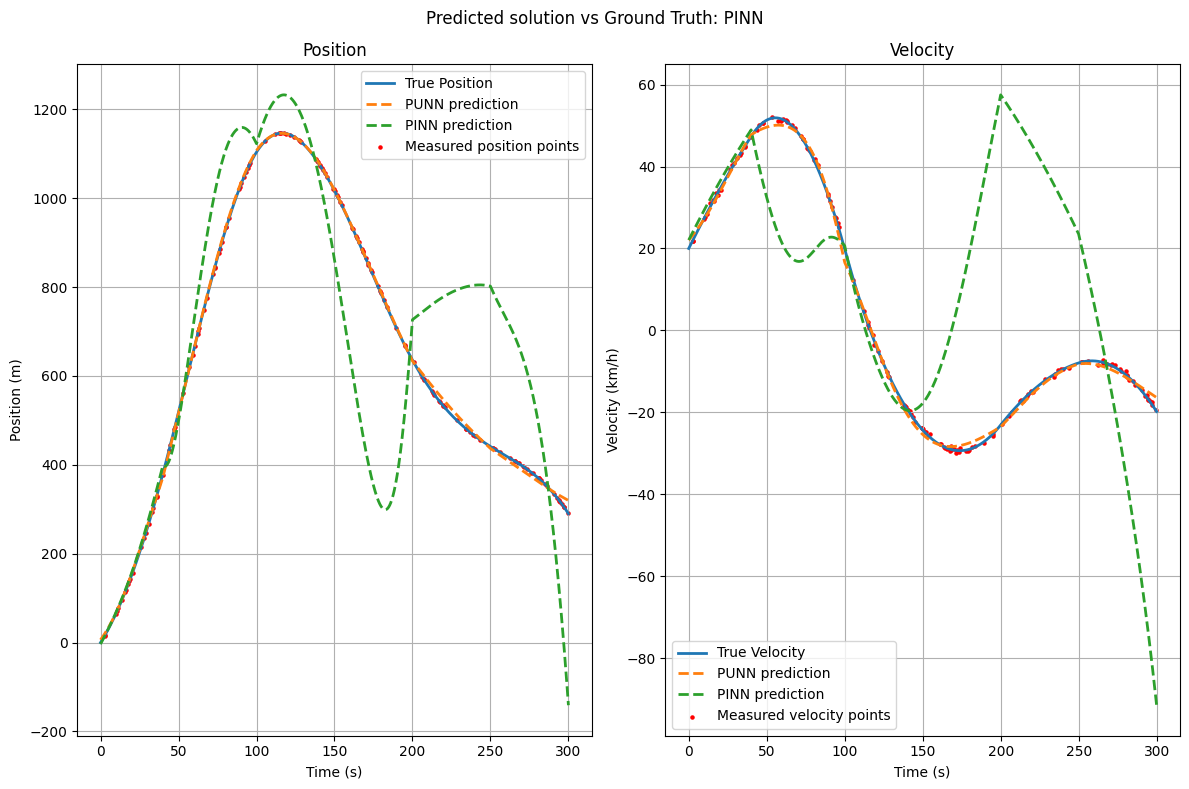

In [18]:
#PUNN
#punn_model = load_model("punn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
print("---PUNN---")
punn_norm = punn_model.predict(X_norm)   #predictions shape will be (3000, 2)
punn_mse_total = mean_squared_error(Y_true_norm, punn_norm)
punn_mse_x = mean_squared_error(Y_true_norm[:, 0], punn_norm[:, 0])
punn_mse_v = mean_squared_error(Y_true_norm[:, 1], punn_norm[:, 1])
print(f"Normalized MSE overall: {punn_mse_total:.5e}")
print(f"Normalized MSE for position: {punn_mse_x:.5e}")
print(f"Normalized MSE for velocity\n: {punn_mse_v:.5e}")

punn = scaler_Y.inverse_transform(punn_norm) #denormalize for true trajectories

#PINN
print("---PINN---")
#pinn_model = load_model("pinn_model_forward.h5", compile=False) #load model just for prediction
#predictions for full t range
pinn_norm = pinn_model.predict(X_norm)   #y shape will be (3000, 2)
pinn_mse_total = mean_squared_error(Y_true_norm, pinn_norm)
pinn_mse_x = mean_squared_error(Y_true_norm[:, 0], pinn_norm[:, 0])
pinn_mse_v = mean_squared_error(Y_true_norm[:, 1], pinn_norm[:, 1])
print(f"Normalized MSE overall: {pinn_mse_total:.5e}")
print(f"Normalized MSE for position: {pinn_mse_x:.5e}")
print(f"Normalized MSE for velocity: {pinn_mse_v:.5e}")

pinn = scaler_Y.inverse_transform(pinn_norm) #denormalize for true trajectories

comparison_plot(t, Y_true, Y_mask, [(punn, "PUNN prediction"), (pinn, "PINN prediction")], suptitle="Predicted solution vs Ground Truth: PINN")
